***Guneykan Ozkaya***

***First Part:***

Feed Forward Neural Networks from Scratch using stochastic gradient descent

***Second Part:***

Approximating Black-Scholes Partial Differential Equation, which prices call options given; stock price, strike price, remaining time to maturity and volatility

# Defining Network

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Dense Layer

Output of the each layer is the transformation of the output of previous layers. And the performance determined by the loss function, we are trying maximize likelihood equivalently trying to minimize negative log likelihood. Thus we update the parameters of network with partial derivatives of loss function with respect to each parameter. We scale by a learning rate to prevent gradient to jump around and not settle in lowest local minima that is possible.

To get the gradients of loss function, we use the chain rule:

$$\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial y_j}\frac{\partial y_j}{\partial x_i}$$

Since every input of a certain layer is output of previous one, we can store input derivative of each layer and transfer it to previous layer during backprop.

Using chain rule we obtain the necessary formulas that we need to update parameters of the network.

Considering output layer, the gradients we need:

***Derivative with respect to its input:***
$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \omega^T$$

***Derivative with respect to weight matrix:***
$$\frac{\partial L}{\partial \omega} = X^T \frac{\partial L}{\partial Y}$$

***Derivative with respect to bias vector:***
$$\frac{\partial L}{\partial B} = \frac{\partial L}{\partial Y}$$

Below function implements a fully connected layer:

 - Forward refers to linear operation which produces output that will be transferred to activation function which will correspond to next layer.
 
 
 - Backward refers to backprop. which takes derivative of loss function with respect to layer's output as argument, calculates the derivatives with respect to its own input and weights, updates its weights and biases then returns the derivative of loss function with respect to its own input



In [9]:
class Dense:
    def __init__(self, feat_size, out_size):
        # remember weights -> (inp, out) size
        self.feat_size = feat_size
        self.out_size = out_size
        # He initialization
        self.weights = (np.random.normal(0, 1, feat_size*out_size)
                        * np.sqrt(2/feat_size)).reshape(feat_size, out_size)
        self.bias = np.random.rand(1, out_size) - 0.5

    def forward(self, input_data):
        self.input = input_data
        # Linear Pass
        self.output = np.dot(self.input, self.weights) + self.bias
        return(self.output)
    # note that backward takes output_der as argument which will come from next layer
    # last layer in our network will just take the derivative of loss function with respect to
    # its prediction

    def backward(self, output_der, lr):  # output_der = dLoss/dY
        input_der = np.dot(output_der, self.weights.T)
        weight_der = np.dot(self.input.T.reshape(-1, 1), output_der)
        # note that der. with respect to bias is output_der
        # updating parameters
        self.weights -= lr*weight_der
        self.bias -= lr*output_der
        # we will need this for the prev. layer(its prev layer's output_der)
        return(input_der)

## Activation Function and Layer

Instead of implementing activation function inside of the layer, implementing as seperate layer simplifies the backprop. This layer will not update any parameters, it will just return the derivative of the loss function with respect to activation function to previous fully connected layer, which is the argument fully connected layer requires to update its parameters.

In the forward pass, activation layer will take output of dense layer and will transfer it after applying ReLu function.

In [10]:
def relu(x):  # Defining activation function
    return(np.maximum(0, x))


def relu_prime(x):  #  Defining derivative of activation function
    x[x > 0] = 1
    x[x <= 0] = 0  # Setting derivative to 0 at the point ReLu is not differentiable
    return x

In [11]:
class ActLayer:
    def __init__(self, act, act_prime):
        self.act = act
        self.act_prime = act_prime

    # Takes the input returns output of activation function
    def forward(self, input_data):
        self.input = input_data
        self.output = self.act(self.input)
        return(self.output)

    # Note that we are not updating any parameters here
    # we gave learning rate as parameter because we will define fit method in a way all layers will require it.
    def backward(self, output_der, lr):
        return(self.act_prime(self.input)*output_der)

## Loss Function and its Derivative

In [12]:
# Using Mean-Squared-Error
def mse(y_true, y_pred):
    return(np.mean((y_pred - y_true)**2))


def mse_prime(y_true, y_pred):
    return(2*(y_pred - y_true)/y_true.size)

In [13]:
class Network:
    def __init__(self, loss, loss_prime):  # Initialize with loss function and its derivative
        self.layers = []  #  list to store layers
        self.loss = loss
        self.loss_prime = loss_prime

    # will add layers to graph
    def add(self, layer):
        self.layers.append(layer)

    # implementing only forward-pass for prediction
    def predict(self, input_data):
        result = []  # will hold the output of last layer

        for a in range(len(input_data)):
            layer_output = input_data[a]
            for layer in self.layers:
                # moving vectors from layer to layer
                layer_output = layer.forward(layer_output)
            result.append(layer_output)

        return(result)

    # Training
    def fit(self, X_train, y_train, epochs, lr):

        for a in range(epochs):  # Number of iterations
            err = 0

            # 1 forward-backward pass for each data-point -> Stochastic. Grad. Descent
            for j in range(len(X_train)):
                layer_output = X_train[j]
                for layer in self.layers:
                    layer_output = layer.forward(layer_output)

                # For Visual Purposes
                err += self.loss(y_train[j], layer_output)

                # backprop note that looping over layers in reverse order
                # initialy we will give derivative of loss with respect to prediction
                # Then output layer will calculate derivative with respect to its input
                # and will pass this input derivative to prev. layer which correspond to its output derivative
                # and that layer will repeat same process, by passing its input derivative to prev. layer

                gradient = self.loss_prime(
                    y_train[j], layer_output)  # dL/dY_hat
                # this loop is the reason we gave lr to activation layer as argument
                for layer in reversed(self.layers):
                    # Setting gradient to dY/dh_{i+1} of current layer
                    gradient = layer.backward(gradient, lr)

            err /= len(X_train)
            print('epoch %d/%d   error=%f' % (a+1, epochs, err))

## Solving XOR for testing Purposes

In [45]:
x_train = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])
x_train = x_train.reshape(-1, 2)
y_train = y_train.reshape(-1, 1)

# network
model = Network(mse, mse_prime)
model.add(Dense(2, 3))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(3, 1))

# train
model.fit(x_train, y_train, epochs=2000, lr=0.01)

# test
y_pred = net.predict(x_train)

epoch 1/2000   error=0.637411
epoch 2/2000   error=0.521485
epoch 3/2000   error=0.445269
epoch 4/2000   error=0.395321
epoch 5/2000   error=0.362639
epoch 6/2000   error=0.341195
epoch 7/2000   error=0.326987
epoch 8/2000   error=0.317395
epoch 9/2000   error=0.310723
epoch 10/2000   error=0.305890
epoch 11/2000   error=0.302210
epoch 12/2000   error=0.299256
epoch 13/2000   error=0.296758
epoch 14/2000   error=0.294550
epoch 15/2000   error=0.292527
epoch 16/2000   error=0.290625
epoch 17/2000   error=0.288803
epoch 18/2000   error=0.287034
epoch 19/2000   error=0.285303
epoch 20/2000   error=0.283598
epoch 21/2000   error=0.281912
epoch 22/2000   error=0.280239
epoch 23/2000   error=0.278577
epoch 24/2000   error=0.276921
epoch 25/2000   error=0.275270
epoch 26/2000   error=0.273622
epoch 27/2000   error=0.271976
epoch 28/2000   error=0.270329
epoch 29/2000   error=0.268682
epoch 30/2000   error=0.267032
epoch 31/2000   error=0.265380
epoch 32/2000   error=0.263723
epoch 33/2000   e

epoch 440/2000   error=0.000108
epoch 441/2000   error=0.000105
epoch 442/2000   error=0.000101
epoch 443/2000   error=0.000098
epoch 444/2000   error=0.000095
epoch 445/2000   error=0.000092
epoch 446/2000   error=0.000088
epoch 447/2000   error=0.000085
epoch 448/2000   error=0.000083
epoch 449/2000   error=0.000080
epoch 450/2000   error=0.000077
epoch 451/2000   error=0.000074
epoch 452/2000   error=0.000072
epoch 453/2000   error=0.000069
epoch 454/2000   error=0.000067
epoch 455/2000   error=0.000065
epoch 456/2000   error=0.000063
epoch 457/2000   error=0.000061
epoch 458/2000   error=0.000059
epoch 459/2000   error=0.000057
epoch 460/2000   error=0.000055
epoch 461/2000   error=0.000053
epoch 462/2000   error=0.000051
epoch 463/2000   error=0.000049
epoch 464/2000   error=0.000048
epoch 465/2000   error=0.000046
epoch 466/2000   error=0.000045
epoch 467/2000   error=0.000043
epoch 468/2000   error=0.000041
epoch 469/2000   error=0.000040
epoch 470/2000   error=0.000039
epoch 47

epoch 863/2000   error=0.000000
epoch 864/2000   error=0.000000
epoch 865/2000   error=0.000000
epoch 866/2000   error=0.000000
epoch 867/2000   error=0.000000
epoch 868/2000   error=0.000000
epoch 869/2000   error=0.000000
epoch 870/2000   error=0.000000
epoch 871/2000   error=0.000000
epoch 872/2000   error=0.000000
epoch 873/2000   error=0.000000
epoch 874/2000   error=0.000000
epoch 875/2000   error=0.000000
epoch 876/2000   error=0.000000
epoch 877/2000   error=0.000000
epoch 878/2000   error=0.000000
epoch 879/2000   error=0.000000
epoch 880/2000   error=0.000000
epoch 881/2000   error=0.000000
epoch 882/2000   error=0.000000
epoch 883/2000   error=0.000000
epoch 884/2000   error=0.000000
epoch 885/2000   error=0.000000
epoch 886/2000   error=0.000000
epoch 887/2000   error=0.000000
epoch 888/2000   error=0.000000
epoch 889/2000   error=0.000000
epoch 890/2000   error=0.000000
epoch 891/2000   error=0.000000
epoch 892/2000   error=0.000000
epoch 893/2000   error=0.000000
epoch 89

epoch 1278/2000   error=0.000000
epoch 1279/2000   error=0.000000
epoch 1280/2000   error=0.000000
epoch 1281/2000   error=0.000000
epoch 1282/2000   error=0.000000
epoch 1283/2000   error=0.000000
epoch 1284/2000   error=0.000000
epoch 1285/2000   error=0.000000
epoch 1286/2000   error=0.000000
epoch 1287/2000   error=0.000000
epoch 1288/2000   error=0.000000
epoch 1289/2000   error=0.000000
epoch 1290/2000   error=0.000000
epoch 1291/2000   error=0.000000
epoch 1292/2000   error=0.000000
epoch 1293/2000   error=0.000000
epoch 1294/2000   error=0.000000
epoch 1295/2000   error=0.000000
epoch 1296/2000   error=0.000000
epoch 1297/2000   error=0.000000
epoch 1298/2000   error=0.000000
epoch 1299/2000   error=0.000000
epoch 1300/2000   error=0.000000
epoch 1301/2000   error=0.000000
epoch 1302/2000   error=0.000000
epoch 1303/2000   error=0.000000
epoch 1304/2000   error=0.000000
epoch 1305/2000   error=0.000000
epoch 1306/2000   error=0.000000
epoch 1307/2000   error=0.000000
epoch 1308

epoch 1705/2000   error=0.000000
epoch 1706/2000   error=0.000000
epoch 1707/2000   error=0.000000
epoch 1708/2000   error=0.000000
epoch 1709/2000   error=0.000000
epoch 1710/2000   error=0.000000
epoch 1711/2000   error=0.000000
epoch 1712/2000   error=0.000000
epoch 1713/2000   error=0.000000
epoch 1714/2000   error=0.000000
epoch 1715/2000   error=0.000000
epoch 1716/2000   error=0.000000
epoch 1717/2000   error=0.000000
epoch 1718/2000   error=0.000000
epoch 1719/2000   error=0.000000
epoch 1720/2000   error=0.000000
epoch 1721/2000   error=0.000000
epoch 1722/2000   error=0.000000
epoch 1723/2000   error=0.000000
epoch 1724/2000   error=0.000000
epoch 1725/2000   error=0.000000
epoch 1726/2000   error=0.000000
epoch 1727/2000   error=0.000000
epoch 1728/2000   error=0.000000
epoch 1729/2000   error=0.000000
epoch 1730/2000   error=0.000000
epoch 1731/2000   error=0.000000
epoch 1732/2000   error=0.000000
epoch 1733/2000   error=0.000000
epoch 1734/2000   error=0.000000
epoch 1735

In [58]:
print(" Real Output:", "\n",
      list(y_train.reshape(-1,)), "\n",
      "------------", "\n",
      "Predictions:", "\n",
      [round(np.float(a)) for a in y_pred])

 Real Output: 
 [0, 1, 1, 0] 
 ------------ 
 Predictions: 
 [0, 1, 1, 0]


## Solving Mnist

In [59]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

y_train = to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255

y_test = to_categorical(y_test)

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [79]:
# Network
model = Network(mse, mse_prime)
model.add(Dense(28*28, 100))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(100, 50))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(50, 10))

# train on 1000 samples
# training will be slow if we update at each iteration on 60000 samples
model.fit(x_train[0:2000], y_train[0:2000], epochs=182, lr=0.1)

epoch 1/182   error=0.048790
epoch 2/182   error=0.024344
epoch 3/182   error=0.017429
epoch 4/182   error=0.013660
epoch 5/182   error=0.011023
epoch 6/182   error=0.009261
epoch 7/182   error=0.007796
epoch 8/182   error=0.006788
epoch 9/182   error=0.005946
epoch 10/182   error=0.005235
epoch 11/182   error=0.004624
epoch 12/182   error=0.004135
epoch 13/182   error=0.003744
epoch 14/182   error=0.003397
epoch 15/182   error=0.003042
epoch 16/182   error=0.002784
epoch 17/182   error=0.002564
epoch 18/182   error=0.002378
epoch 19/182   error=0.002247
epoch 20/182   error=0.002105
epoch 21/182   error=0.001977
epoch 22/182   error=0.001854
epoch 23/182   error=0.001745
epoch 24/182   error=0.001669
epoch 25/182   error=0.001584
epoch 26/182   error=0.001512
epoch 27/182   error=0.001455
epoch 28/182   error=0.001397
epoch 29/182   error=0.001333
epoch 30/182   error=0.001297
epoch 31/182   error=0.001251
epoch 32/182   error=0.001198
epoch 33/182   error=0.001169
epoch 34/182   erro

***Considering its using MSE as loss function and dense layers, its predictions are good enough***

In [80]:
print(" Real Output:", "\n",
      y_test[0:5], "\n",
      "--------------------------------", "\n",
      "Predictions:", "\n",
      np.round(net.predict(x_test[0:5])))

 Real Output: 
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 
 -------------------------------- 
 Predictions: 
 [[[-0.  0. -0. -0. -0.  0.  0.  1. -0.  0.]]

 [[ 0. -0.  0.  0.  0.  0.  0.  0.  0. -0.]]

 [[ 0.  1. -0. -0.  0. -0.  0. -0. -0.  0.]]

 [[ 1.  0. -0. -0. -0. -0.  0. -0. -0.  0.]]

 [[-0. -0.  0. -0.  1. -0.  0.  0.  0. -0.]]]


# Approximating Black-Scholes Partial Differential Equation with FFNNs

## Generating Stock Prices

***Black and Scholes stochastic differential equation for stock prices:***

$$dS_t = S_0(\sigma dB_t + rdt)$$

***Solution is given by:***

$$S_t = S_0e^{\sigma(B_t - B_0) + (r - \frac{1}{2}\sigma^2)t}$$

***Discretizing it:***

$$log(S_t) - log(S_0) = \sigma N(0, t) + (r - \frac{1}{2}\sigma^2)t$$

***$B_t$*** : Brownian Motion

***$S_i$*** : Stock price at time i

***$r$*** : Risk Free rate

***$\sigma$*** : Predicted Volatility, taken as constant for simplecity

***Black and Scholes Partial Differential Equation for Option Prices:***

$$rF(t, S_t) = \frac{\partial F}{\partial t}(t, S_t) + rS_t\frac{\partial F}{\partial x}(t, S_t) + \frac{1}{2}\sigma^2 S_t^2\frac{F}{x^2}(t, S_t)$$

***Solution is given by:***

$$C_0 = S_0\mathcal{N}(d_1) - e^{-rT}K\mathcal{N}(d_2)$$

Solution is too long and out of the context of this project. Solution can be obtained 2 ways, first; using bionomial tree approach, going from discrete case to continous, second; solving the the PDE by several change of variables then we obtain heat equation.

I can provide notes on both methods, if anyone interested can contact with me.

For original resources, refer to:

First approach: Cox-Rubinstein, OPTION PRICING: A SIMPLIFIED APPROACH

Second approach: Black-Scholes The Pricing of options and Corporate Liabilities.


In [83]:
vol = 0.17  # volatility (standard deviation), sigma of SDE and PDE
T = 1/2  # Maturity
n = 1000  #  Number of steps that we use to discretize above process
s_0 = 100  # Initial stock price correspond to S_0 in the above functions
r = 0.05  #  Risk Free rate, drift term of SDE -> r
k = 100  # Strike price of the option -> K

In [84]:
def calculate_spot(prev, sigma, r, step, random):

    # Solution of Stochastic differential equation, log term avoided
    return(prev + (sigma*prev*random) + (r*prev*step))


def sim_spot(s0, r, steps, maturity, vol):
    delta_t = T/steps
    time = np.round(np.arange(0, maturity+delta_t, delta_t),
                    4)  # dividing maturity into 1000 steps
    prices = [s0]
    # Discretezing brownian motion increment
    normal_dist = np.random.normal(0, np.sqrt(delta_t), 10000)
    for a in range(steps):
        prices.append(calculate_spot(
            prices[-1], vol, r, delta_t, normal_dist[a]))
    return(prices)

In [85]:
# Generating 5 different path to test the functions
# I will use only 1 path in the training of network
sims = pd.DataFrame()
for a in range(5):
    sims[a] = sim_spot(s_0, r, n, T, vol)

sims.columns = ["Sim_1", "Sim_2", "Sim_3", "Sim_4", "Sim_5"]
sims.index = np.round(np.arange(0, 0.5+(0.5/1000), 0.5/1000), 4)

[Text(0, 0.5, 'Prices'), Text(0.5, 0, 'Steps'), Text(0.5, 1.0, 'Simulations')]

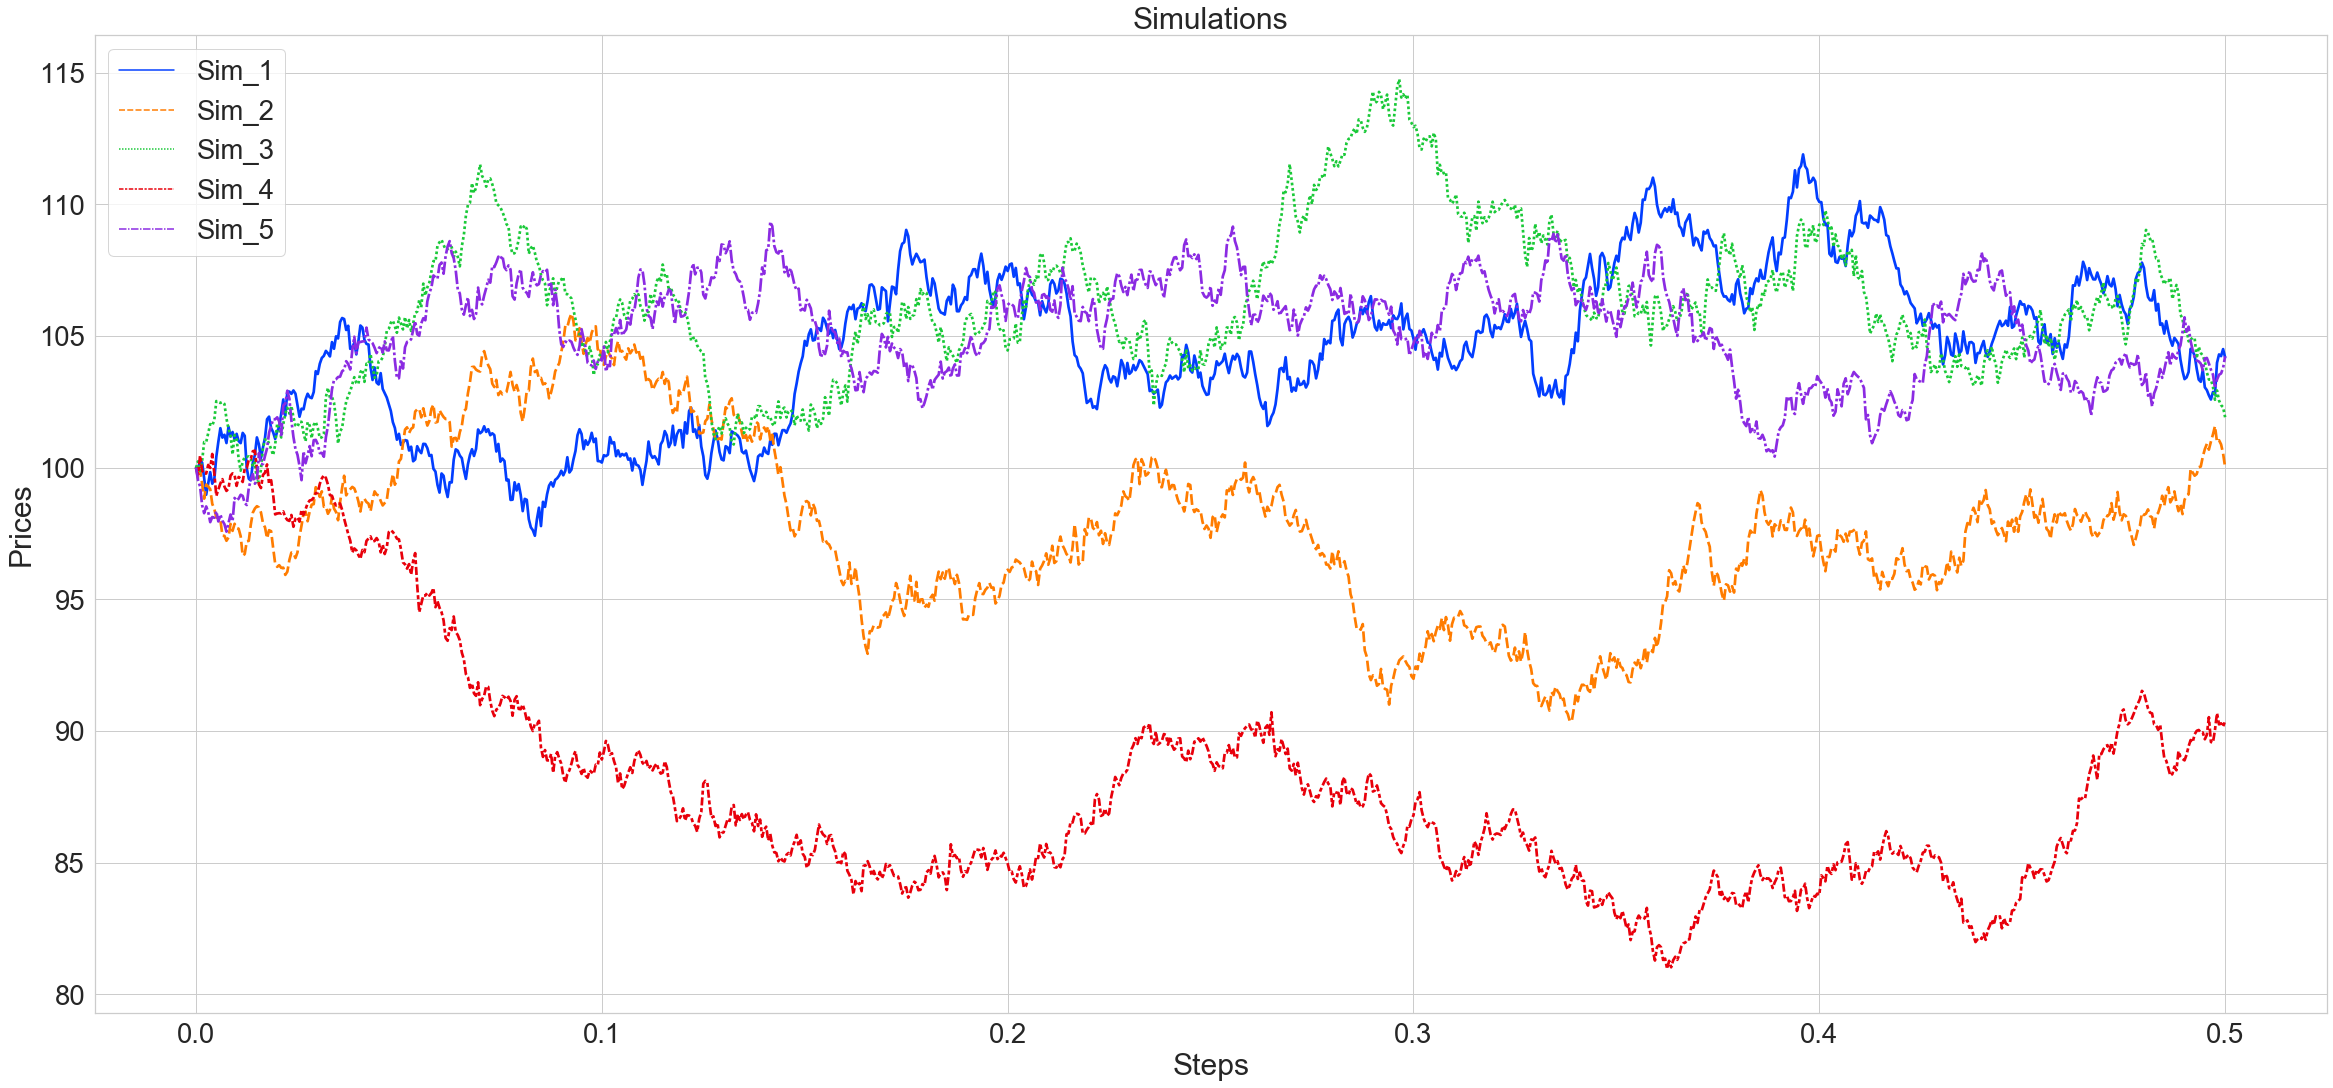

In [97]:
sns.set(style="whitegrid", font_scale=2.5)
plt.figure(figsize=(40, 18))
ax = sns.lineplot(data=sims, palette="bright", linewidth=2.7)
ax.set(xlabel='Steps', ylabel='Prices', title="Simulations")

## Generating Option Prices

In [89]:
def d1(s, k, r, t, T, vol):  # d1 of the call price solution(PDE)
    if T != t:
        nomin = np.log(s/k) + (r + 0.5*(vol**2))*(T-t)
        denom = vol*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None


def d2(s, k, r, t, T, vol):  # d2 of the call price solution(PDE)
    if T != t:
        nomin = np.log(s/k) + (r - 0.5*(vol**2))*(T-t)
        denom = vol*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None


def call(d1, d2, k, r, T, t, s):  # PDE solution
    return(s*scipy.stats.norm.cdf(d1) - k*np.exp(-r*(T-t))*scipy.stats.norm.cdf(d2))

In [91]:
call_prices = []
maturity = []
for (a, b) in zip(sims["Sim_1"], sims.index):
    if b != T:
        d1_ = d1(a, k, r, b, T, vol)
        d2_ = d2(a, k, r, b, T, vol)
        call_prices.append(call(d1_, d2_, k, r, T, b, a))
        maturity.append((T-b))
    else:
        call_prices.append(max(a-k, 0))
        maturity.append(0)

In [92]:
opt_price = pd.DataFrame(call_prices, sims.index)
opt_price = opt_price.rename(columns={0: "Sim_1_Call"})
opt_price = pd.concat([opt_price, sims["Sim_1"]], axis=1)
min_max = MinMaxScaler(feature_range=(min(call_prices), max(call_prices)))
opt_price["Sim_1_scaled"] = min_max.fit_transform(
    opt_price["Sim_1"].values.reshape(-1, 1))
opt_price.index = pd.date_range(
    start='01/01/2018', end='06/01/2018', periods=1001)

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Scaled Stock Price - Call Price')]

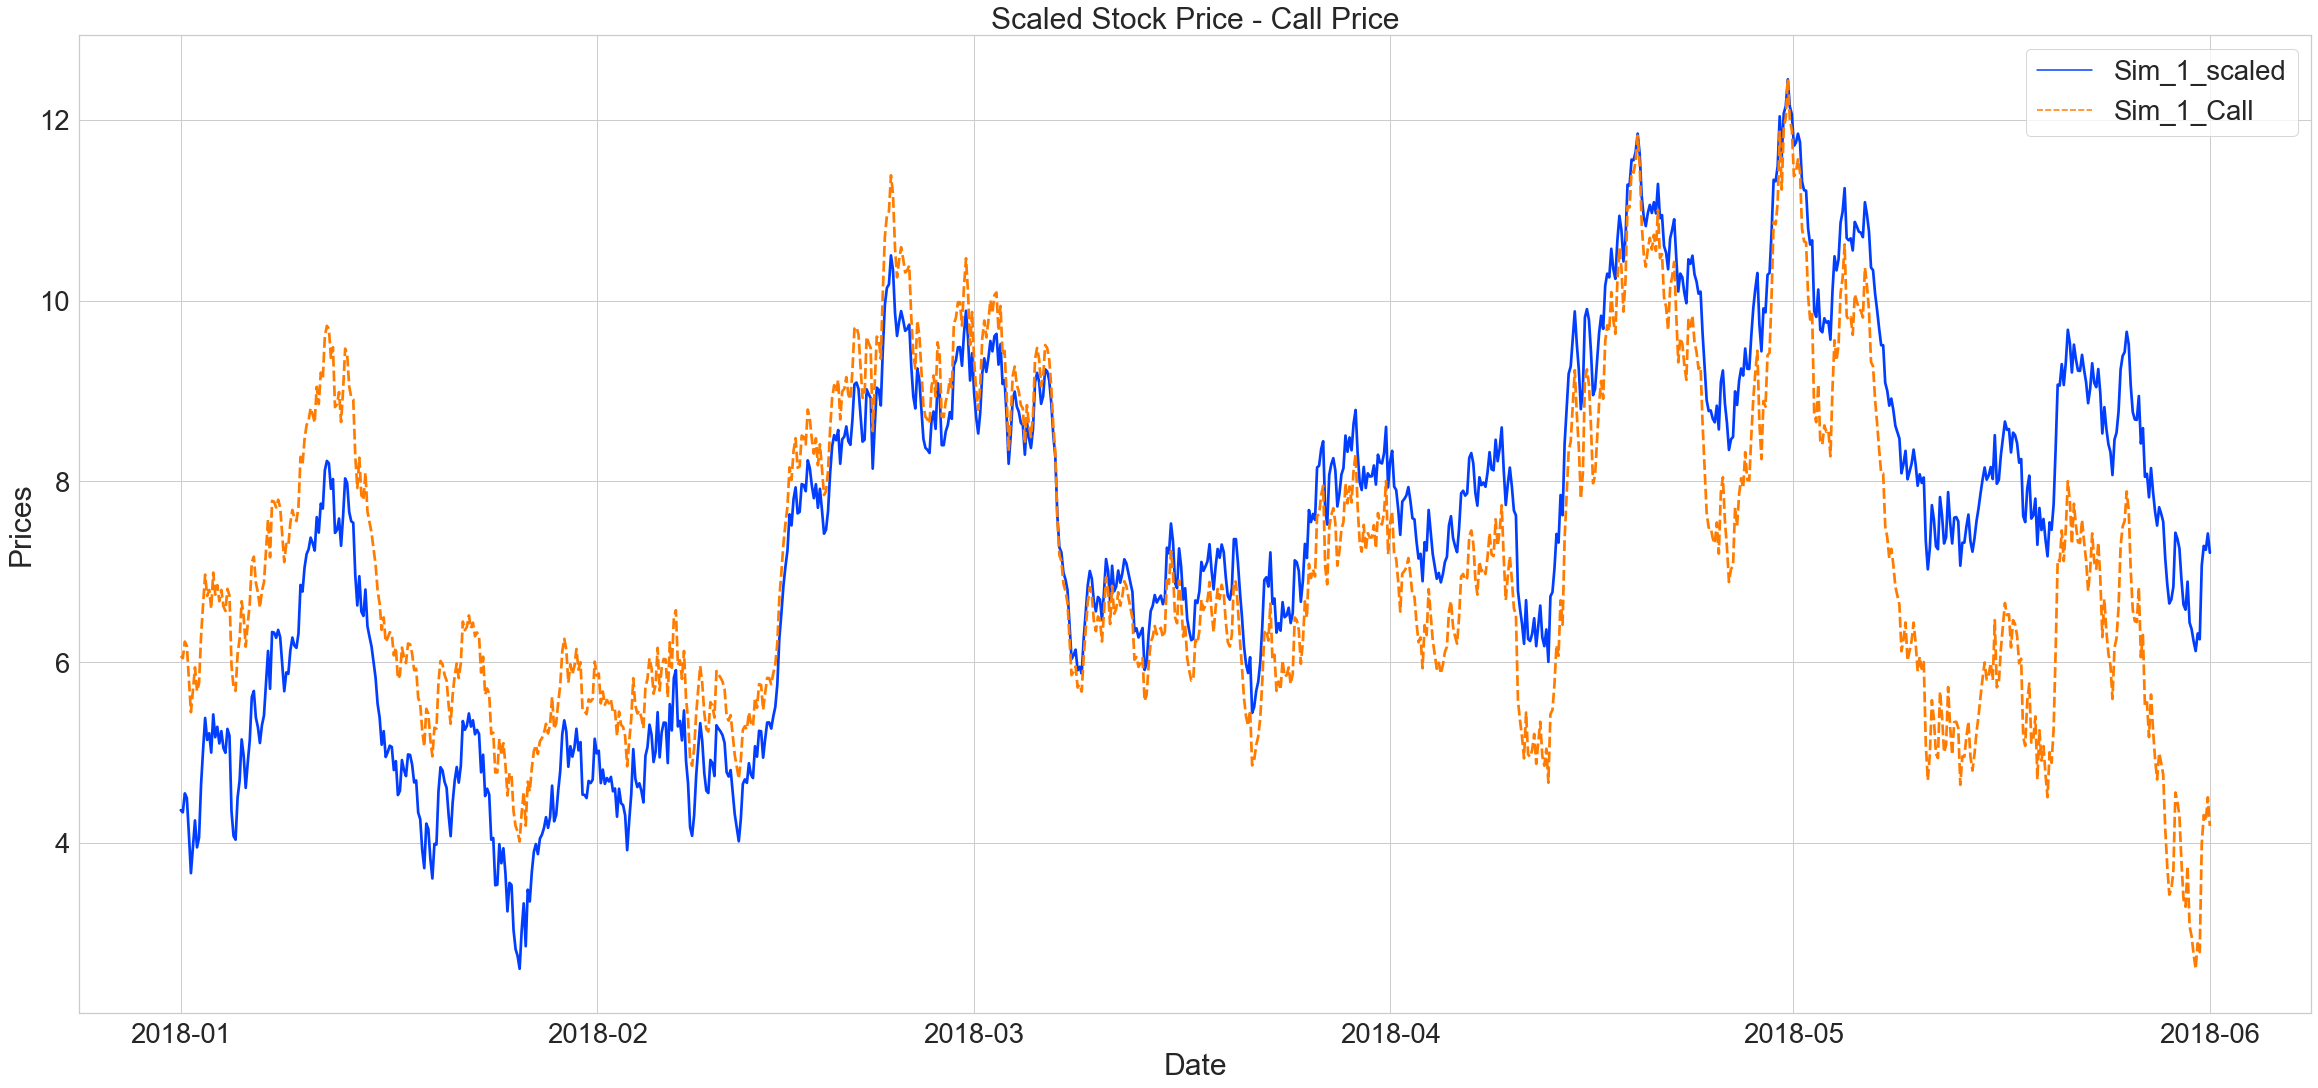

In [99]:
sns.set(style="whitegrid", font_scale=2.5)
plt.figure(figsize=(40, 18))
ax = sns.lineplot(
    data=opt_price[["Sim_1_scaled", "Sim_1_Call"]], palette="bright", linewidth=2.7)
ax.set(xlabel='Date', ylabel='Prices', title="Scaled Stock Price - Call Price")

## Preparing Data for Training

In [101]:
opt_price["Maturity"] = maturity
opt_price["Strike"] = k
opt_price["Risk_Free"] = r
opt_price["Volatility"] = vol
model_data = opt_price.drop(["Sim_1_scaled"], axis=1)

In [113]:
train_data = model_data.iloc[:round(len(model_data) * 0.8)]  # 80-20 split
test_data = model_data.iloc[len(train_data):]

In [116]:
X_train = train_data.drop(["Sim_1_Call"], axis=1).values
y_train = train_data["Sim_1_Call"].values

X_test = test_data.drop(["Sim_1_Call"], axis=1).values
y_test = test_data["Sim_1_Call"].values

min_max = MinMaxScaler()

X_train = min_max.fit_transform(X_train)
# Scaling test data by min-max values of training data
X_test = min_max.transform(X_test)

print(" X_train shape:", X_train.shape, "\n",
      "y_train shape:", y_train.shape, "\n",
      "X_test shape:", X_test.shape, "\n",
      "y_test shape:", y_test.shape)

 X_train shape: (801, 5) 
 y_train shape: (801,) 
 X_test shape: (200, 5) 
 y_test shape: (200,)


## Training

***Training for 10 epochs***

In [150]:
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

model.fit(X_train, y_train, epochs=10, lr=0.001)

y_pred_10 = model.predict(X_test)
y_pred_10 = [np.float(a) for a in y_pred_10]

epoch 1/10   error=0.162568
epoch 2/10   error=0.140373
epoch 3/10   error=0.048899
epoch 4/10   error=0.018323
epoch 5/10   error=0.007783
epoch 6/10   error=0.005509
epoch 7/10   error=0.005154
epoch 8/10   error=0.004777
epoch 9/10   error=0.004217
epoch 10/10   error=0.003660


***Training for 100 epochs***

In [151]:
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

model.fit(X_train, y_train, epochs=100, lr=0.001)

y_pred_100 = model.predict(X_test)
y_pred_100 = [np.float(a) for a in y_pred_100]

epoch 1/100   error=0.143175
epoch 2/100   error=0.071069
epoch 3/100   error=0.029026
epoch 4/100   error=0.013734
epoch 5/100   error=0.007766
epoch 6/100   error=0.005350
epoch 7/100   error=0.004121
epoch 8/100   error=0.003338
epoch 9/100   error=0.002738
epoch 10/100   error=0.002281
epoch 11/100   error=0.001945
epoch 12/100   error=0.001693
epoch 13/100   error=0.001520
epoch 14/100   error=0.001395
epoch 15/100   error=0.001311
epoch 16/100   error=0.001234
epoch 17/100   error=0.001170
epoch 18/100   error=0.001109
epoch 19/100   error=0.001070
epoch 20/100   error=0.001025
epoch 21/100   error=0.000970
epoch 22/100   error=0.000938
epoch 23/100   error=0.000906
epoch 24/100   error=0.000869
epoch 25/100   error=0.000833
epoch 26/100   error=0.000806
epoch 27/100   error=0.000782
epoch 28/100   error=0.000761
epoch 29/100   error=0.000744
epoch 30/100   error=0.000718
epoch 31/100   error=0.000697
epoch 32/100   error=0.000677
epoch 33/100   error=0.000659
epoch 34/100   erro

***Training for 200 epochs***

In [152]:
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

model.fit(X_train, y_train, epochs=200, lr=0.001)

y_pred_200 = model.predict(X_test)
y_pred_200 = [np.float(a) for a in y_pred_200]

epoch 1/200   error=0.161255
epoch 2/200   error=0.111446
epoch 3/200   error=0.041804
epoch 4/200   error=0.016958
epoch 5/200   error=0.010415
epoch 6/200   error=0.009156
epoch 7/200   error=0.008306
epoch 8/200   error=0.007094
epoch 9/200   error=0.005874
epoch 10/200   error=0.004883
epoch 11/200   error=0.004103
epoch 12/200   error=0.003499
epoch 13/200   error=0.002994
epoch 14/200   error=0.002566
epoch 15/200   error=0.002232
epoch 16/200   error=0.001963
epoch 17/200   error=0.001735
epoch 18/200   error=0.001552
epoch 19/200   error=0.001407
epoch 20/200   error=0.001278
epoch 21/200   error=0.001180
epoch 22/200   error=0.001093
epoch 23/200   error=0.001025
epoch 24/200   error=0.000965
epoch 25/200   error=0.000911
epoch 26/200   error=0.000885
epoch 27/200   error=0.000848
epoch 28/200   error=0.000831
epoch 29/200   error=0.000805
epoch 30/200   error=0.000768
epoch 31/200   error=0.000743
epoch 32/200   error=0.000708
epoch 33/200   error=0.000677
epoch 34/200   erro

***Training for 1000 epochs***

In [153]:
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

model.fit(X_train, y_train, epochs=1000, lr=0.001)

y_pred_1k = model.predict(X_test)
y_pred_1k = [np.float(a) for a in y_pred_1k]

epoch 1/1000   error=0.154925
epoch 2/1000   error=0.133283
epoch 3/1000   error=0.045268
epoch 4/1000   error=0.016495
epoch 5/1000   error=0.007469
epoch 6/1000   error=0.004875
epoch 7/1000   error=0.004111
epoch 8/1000   error=0.003606
epoch 9/1000   error=0.003164
epoch 10/1000   error=0.002783
epoch 11/1000   error=0.002425
epoch 12/1000   error=0.002170
epoch 13/1000   error=0.001957
epoch 14/1000   error=0.001766
epoch 15/1000   error=0.001589
epoch 16/1000   error=0.001439
epoch 17/1000   error=0.001324
epoch 18/1000   error=0.001232
epoch 19/1000   error=0.001146
epoch 20/1000   error=0.001077
epoch 21/1000   error=0.001013
epoch 22/1000   error=0.000957
epoch 23/1000   error=0.000906
epoch 24/1000   error=0.000864
epoch 25/1000   error=0.000821
epoch 26/1000   error=0.000792
epoch 27/1000   error=0.000760
epoch 28/1000   error=0.000735
epoch 29/1000   error=0.000719
epoch 30/1000   error=0.000700
epoch 31/1000   error=0.000680
epoch 32/1000   error=0.000670
epoch 33/1000   e

epoch 261/1000   error=0.000109
epoch 262/1000   error=0.000109
epoch 263/1000   error=0.000108
epoch 264/1000   error=0.000109
epoch 265/1000   error=0.000109
epoch 266/1000   error=0.000107
epoch 267/1000   error=0.000108
epoch 268/1000   error=0.000107
epoch 269/1000   error=0.000107
epoch 270/1000   error=0.000107
epoch 271/1000   error=0.000107
epoch 272/1000   error=0.000106
epoch 273/1000   error=0.000105
epoch 274/1000   error=0.000106
epoch 275/1000   error=0.000106
epoch 276/1000   error=0.000105
epoch 277/1000   error=0.000104
epoch 278/1000   error=0.000105
epoch 279/1000   error=0.000104
epoch 280/1000   error=0.000104
epoch 281/1000   error=0.000103
epoch 282/1000   error=0.000101
epoch 283/1000   error=0.000100
epoch 284/1000   error=0.000101
epoch 285/1000   error=0.000100
epoch 286/1000   error=0.000097
epoch 287/1000   error=0.000099
epoch 288/1000   error=0.000099
epoch 289/1000   error=0.000097
epoch 290/1000   error=0.000098
epoch 291/1000   error=0.000097
epoch 29

epoch 518/1000   error=0.000057
epoch 519/1000   error=0.000057
epoch 520/1000   error=0.000057
epoch 521/1000   error=0.000056
epoch 522/1000   error=0.000056
epoch 523/1000   error=0.000056
epoch 524/1000   error=0.000056
epoch 525/1000   error=0.000056
epoch 526/1000   error=0.000056
epoch 527/1000   error=0.000056
epoch 528/1000   error=0.000056
epoch 529/1000   error=0.000056
epoch 530/1000   error=0.000055
epoch 531/1000   error=0.000055
epoch 532/1000   error=0.000055
epoch 533/1000   error=0.000055
epoch 534/1000   error=0.000055
epoch 535/1000   error=0.000055
epoch 536/1000   error=0.000055
epoch 537/1000   error=0.000055
epoch 538/1000   error=0.000055
epoch 539/1000   error=0.000054
epoch 540/1000   error=0.000055
epoch 541/1000   error=0.000054
epoch 542/1000   error=0.000054
epoch 543/1000   error=0.000055
epoch 544/1000   error=0.000054
epoch 545/1000   error=0.000054
epoch 546/1000   error=0.000054
epoch 547/1000   error=0.000054
epoch 548/1000   error=0.000054
epoch 54

epoch 775/1000   error=0.000039
epoch 776/1000   error=0.000039
epoch 777/1000   error=0.000039
epoch 778/1000   error=0.000039
epoch 779/1000   error=0.000039
epoch 780/1000   error=0.000039
epoch 781/1000   error=0.000039
epoch 782/1000   error=0.000039
epoch 783/1000   error=0.000039
epoch 784/1000   error=0.000039
epoch 785/1000   error=0.000038
epoch 786/1000   error=0.000038
epoch 787/1000   error=0.000038
epoch 788/1000   error=0.000038
epoch 789/1000   error=0.000038
epoch 790/1000   error=0.000038
epoch 791/1000   error=0.000038
epoch 792/1000   error=0.000038
epoch 793/1000   error=0.000038
epoch 794/1000   error=0.000038
epoch 795/1000   error=0.000038
epoch 796/1000   error=0.000037
epoch 797/1000   error=0.000038
epoch 798/1000   error=0.000038
epoch 799/1000   error=0.000038
epoch 800/1000   error=0.000038
epoch 801/1000   error=0.000038
epoch 802/1000   error=0.000037
epoch 803/1000   error=0.000038
epoch 804/1000   error=0.000037
epoch 805/1000   error=0.000037
epoch 80

***Training for 5000 epochs***

In [147]:
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

model.fit(X_train, y_train, epochs=5000, lr=0.001)

y_pred_5k = model.predict(X_test)
y_pred_5k = [np.float(a) for a in y_pred_5k]

epoch 1/5000   error=0.125712
epoch 2/5000   error=0.094880
epoch 3/5000   error=0.039641
epoch 4/5000   error=0.017172
epoch 5/5000   error=0.008418
epoch 6/5000   error=0.005481
epoch 7/5000   error=0.004505
epoch 8/5000   error=0.003900
epoch 9/5000   error=0.003322
epoch 10/5000   error=0.002827
epoch 11/5000   error=0.002398
epoch 12/5000   error=0.002091
epoch 13/5000   error=0.001864
epoch 14/5000   error=0.001718
epoch 15/5000   error=0.001615
epoch 16/5000   error=0.001542
epoch 17/5000   error=0.001491
epoch 18/5000   error=0.001451
epoch 19/5000   error=0.001425
epoch 20/5000   error=0.001405
epoch 21/5000   error=0.001374
epoch 22/5000   error=0.001345
epoch 23/5000   error=0.001308
epoch 24/5000   error=0.001269
epoch 25/5000   error=0.001229
epoch 26/5000   error=0.001185
epoch 27/5000   error=0.001142
epoch 28/5000   error=0.001106
epoch 29/5000   error=0.001057
epoch 30/5000   error=0.001004
epoch 31/5000   error=0.000948
epoch 32/5000   error=0.000902
epoch 33/5000   e

epoch 261/5000   error=0.000063
epoch 262/5000   error=0.000062
epoch 263/5000   error=0.000063
epoch 264/5000   error=0.000062
epoch 265/5000   error=0.000062
epoch 266/5000   error=0.000062
epoch 267/5000   error=0.000061
epoch 268/5000   error=0.000061
epoch 269/5000   error=0.000061
epoch 270/5000   error=0.000061
epoch 271/5000   error=0.000061
epoch 272/5000   error=0.000060
epoch 273/5000   error=0.000061
epoch 274/5000   error=0.000060
epoch 275/5000   error=0.000060
epoch 276/5000   error=0.000060
epoch 277/5000   error=0.000059
epoch 278/5000   error=0.000060
epoch 279/5000   error=0.000059
epoch 280/5000   error=0.000059
epoch 281/5000   error=0.000059
epoch 282/5000   error=0.000059
epoch 283/5000   error=0.000058
epoch 284/5000   error=0.000059
epoch 285/5000   error=0.000059
epoch 286/5000   error=0.000058
epoch 287/5000   error=0.000058
epoch 288/5000   error=0.000058
epoch 289/5000   error=0.000058
epoch 290/5000   error=0.000058
epoch 291/5000   error=0.000057
epoch 29

epoch 518/5000   error=0.000036
epoch 519/5000   error=0.000037
epoch 520/5000   error=0.000037
epoch 521/5000   error=0.000037
epoch 522/5000   error=0.000037
epoch 523/5000   error=0.000037
epoch 524/5000   error=0.000036
epoch 525/5000   error=0.000036
epoch 526/5000   error=0.000036
epoch 527/5000   error=0.000036
epoch 528/5000   error=0.000036
epoch 529/5000   error=0.000036
epoch 530/5000   error=0.000036
epoch 531/5000   error=0.000036
epoch 532/5000   error=0.000036
epoch 533/5000   error=0.000035
epoch 534/5000   error=0.000036
epoch 535/5000   error=0.000036
epoch 536/5000   error=0.000036
epoch 537/5000   error=0.000036
epoch 538/5000   error=0.000035
epoch 539/5000   error=0.000035
epoch 540/5000   error=0.000035
epoch 541/5000   error=0.000035
epoch 542/5000   error=0.000035
epoch 543/5000   error=0.000035
epoch 544/5000   error=0.000035
epoch 545/5000   error=0.000035
epoch 546/5000   error=0.000035
epoch 547/5000   error=0.000035
epoch 548/5000   error=0.000035
epoch 54

epoch 775/5000   error=0.000026
epoch 776/5000   error=0.000026
epoch 777/5000   error=0.000026
epoch 778/5000   error=0.000026
epoch 779/5000   error=0.000025
epoch 780/5000   error=0.000026
epoch 781/5000   error=0.000026
epoch 782/5000   error=0.000026
epoch 783/5000   error=0.000026
epoch 784/5000   error=0.000026
epoch 785/5000   error=0.000025
epoch 786/5000   error=0.000026
epoch 787/5000   error=0.000026
epoch 788/5000   error=0.000026
epoch 789/5000   error=0.000025
epoch 790/5000   error=0.000025
epoch 791/5000   error=0.000025
epoch 792/5000   error=0.000025
epoch 793/5000   error=0.000025
epoch 794/5000   error=0.000024
epoch 795/5000   error=0.000025
epoch 796/5000   error=0.000024
epoch 797/5000   error=0.000024
epoch 798/5000   error=0.000024
epoch 799/5000   error=0.000024
epoch 800/5000   error=0.000024
epoch 801/5000   error=0.000024
epoch 802/5000   error=0.000024
epoch 803/5000   error=0.000024
epoch 804/5000   error=0.000024
epoch 805/5000   error=0.000024
epoch 80

epoch 1031/5000   error=0.000019
epoch 1032/5000   error=0.000019
epoch 1033/5000   error=0.000019
epoch 1034/5000   error=0.000019
epoch 1035/5000   error=0.000019
epoch 1036/5000   error=0.000019
epoch 1037/5000   error=0.000019
epoch 1038/5000   error=0.000019
epoch 1039/5000   error=0.000019
epoch 1040/5000   error=0.000019
epoch 1041/5000   error=0.000019
epoch 1042/5000   error=0.000019
epoch 1043/5000   error=0.000019
epoch 1044/5000   error=0.000019
epoch 1045/5000   error=0.000019
epoch 1046/5000   error=0.000019
epoch 1047/5000   error=0.000019
epoch 1048/5000   error=0.000019
epoch 1049/5000   error=0.000019
epoch 1050/5000   error=0.000019
epoch 1051/5000   error=0.000019
epoch 1052/5000   error=0.000019
epoch 1053/5000   error=0.000019
epoch 1054/5000   error=0.000019
epoch 1055/5000   error=0.000019
epoch 1056/5000   error=0.000019
epoch 1057/5000   error=0.000019
epoch 1058/5000   error=0.000019
epoch 1059/5000   error=0.000019
epoch 1060/5000   error=0.000019
epoch 1061

epoch 1280/5000   error=0.000017
epoch 1281/5000   error=0.000017
epoch 1282/5000   error=0.000017
epoch 1283/5000   error=0.000017
epoch 1284/5000   error=0.000017
epoch 1285/5000   error=0.000017
epoch 1286/5000   error=0.000017
epoch 1287/5000   error=0.000017
epoch 1288/5000   error=0.000016
epoch 1289/5000   error=0.000017
epoch 1290/5000   error=0.000017
epoch 1291/5000   error=0.000017
epoch 1292/5000   error=0.000017
epoch 1293/5000   error=0.000017
epoch 1294/5000   error=0.000017
epoch 1295/5000   error=0.000017
epoch 1296/5000   error=0.000017
epoch 1297/5000   error=0.000017
epoch 1298/5000   error=0.000017
epoch 1299/5000   error=0.000017
epoch 1300/5000   error=0.000017
epoch 1301/5000   error=0.000017
epoch 1302/5000   error=0.000017
epoch 1303/5000   error=0.000017
epoch 1304/5000   error=0.000017
epoch 1305/5000   error=0.000017
epoch 1306/5000   error=0.000017
epoch 1307/5000   error=0.000016
epoch 1308/5000   error=0.000017
epoch 1309/5000   error=0.000017
epoch 1310

epoch 1529/5000   error=0.000015
epoch 1530/5000   error=0.000015
epoch 1531/5000   error=0.000015
epoch 1532/5000   error=0.000015
epoch 1533/5000   error=0.000015
epoch 1534/5000   error=0.000015
epoch 1535/5000   error=0.000015
epoch 1536/5000   error=0.000015
epoch 1537/5000   error=0.000015
epoch 1538/5000   error=0.000015
epoch 1539/5000   error=0.000015
epoch 1540/5000   error=0.000015
epoch 1541/5000   error=0.000015
epoch 1542/5000   error=0.000015
epoch 1543/5000   error=0.000015
epoch 1544/5000   error=0.000015
epoch 1545/5000   error=0.000015
epoch 1546/5000   error=0.000015
epoch 1547/5000   error=0.000015
epoch 1548/5000   error=0.000015
epoch 1549/5000   error=0.000015
epoch 1550/5000   error=0.000015
epoch 1551/5000   error=0.000015
epoch 1552/5000   error=0.000015
epoch 1553/5000   error=0.000015
epoch 1554/5000   error=0.000015
epoch 1555/5000   error=0.000015
epoch 1556/5000   error=0.000015
epoch 1557/5000   error=0.000015
epoch 1558/5000   error=0.000015
epoch 1559

epoch 1778/5000   error=0.000013
epoch 1779/5000   error=0.000013
epoch 1780/5000   error=0.000013
epoch 1781/5000   error=0.000013
epoch 1782/5000   error=0.000013
epoch 1783/5000   error=0.000013
epoch 1784/5000   error=0.000013
epoch 1785/5000   error=0.000013
epoch 1786/5000   error=0.000013
epoch 1787/5000   error=0.000013
epoch 1788/5000   error=0.000013
epoch 1789/5000   error=0.000013
epoch 1790/5000   error=0.000013
epoch 1791/5000   error=0.000013
epoch 1792/5000   error=0.000013
epoch 1793/5000   error=0.000013
epoch 1794/5000   error=0.000013
epoch 1795/5000   error=0.000013
epoch 1796/5000   error=0.000013
epoch 1797/5000   error=0.000013
epoch 1798/5000   error=0.000013
epoch 1799/5000   error=0.000013
epoch 1800/5000   error=0.000013
epoch 1801/5000   error=0.000013
epoch 1802/5000   error=0.000013
epoch 1803/5000   error=0.000013
epoch 1804/5000   error=0.000013
epoch 1805/5000   error=0.000013
epoch 1806/5000   error=0.000013
epoch 1807/5000   error=0.000013
epoch 1808

epoch 2027/5000   error=0.000012
epoch 2028/5000   error=0.000012
epoch 2029/5000   error=0.000012
epoch 2030/5000   error=0.000012
epoch 2031/5000   error=0.000012
epoch 2032/5000   error=0.000012
epoch 2033/5000   error=0.000012
epoch 2034/5000   error=0.000012
epoch 2035/5000   error=0.000012
epoch 2036/5000   error=0.000012
epoch 2037/5000   error=0.000012
epoch 2038/5000   error=0.000012
epoch 2039/5000   error=0.000012
epoch 2040/5000   error=0.000012
epoch 2041/5000   error=0.000012
epoch 2042/5000   error=0.000012
epoch 2043/5000   error=0.000012
epoch 2044/5000   error=0.000012
epoch 2045/5000   error=0.000012
epoch 2046/5000   error=0.000012
epoch 2047/5000   error=0.000012
epoch 2048/5000   error=0.000012
epoch 2049/5000   error=0.000012
epoch 2050/5000   error=0.000012
epoch 2051/5000   error=0.000012
epoch 2052/5000   error=0.000012
epoch 2053/5000   error=0.000012
epoch 2054/5000   error=0.000012
epoch 2055/5000   error=0.000012
epoch 2056/5000   error=0.000012
epoch 2057

epoch 2276/5000   error=0.000011
epoch 2277/5000   error=0.000011
epoch 2278/5000   error=0.000012
epoch 2279/5000   error=0.000011
epoch 2280/5000   error=0.000011
epoch 2281/5000   error=0.000012
epoch 2282/5000   error=0.000011
epoch 2283/5000   error=0.000011
epoch 2284/5000   error=0.000011
epoch 2285/5000   error=0.000011
epoch 2286/5000   error=0.000011
epoch 2287/5000   error=0.000011
epoch 2288/5000   error=0.000011
epoch 2289/5000   error=0.000011
epoch 2290/5000   error=0.000011
epoch 2291/5000   error=0.000011
epoch 2292/5000   error=0.000011
epoch 2293/5000   error=0.000011
epoch 2294/5000   error=0.000011
epoch 2295/5000   error=0.000011
epoch 2296/5000   error=0.000011
epoch 2297/5000   error=0.000011
epoch 2298/5000   error=0.000011
epoch 2299/5000   error=0.000011
epoch 2300/5000   error=0.000011
epoch 2301/5000   error=0.000011
epoch 2302/5000   error=0.000011
epoch 2303/5000   error=0.000011
epoch 2304/5000   error=0.000011
epoch 2305/5000   error=0.000011
epoch 2306

epoch 2525/5000   error=0.000011
epoch 2526/5000   error=0.000011
epoch 2527/5000   error=0.000011
epoch 2528/5000   error=0.000011
epoch 2529/5000   error=0.000011
epoch 2530/5000   error=0.000011
epoch 2531/5000   error=0.000011
epoch 2532/5000   error=0.000011
epoch 2533/5000   error=0.000011
epoch 2534/5000   error=0.000011
epoch 2535/5000   error=0.000011
epoch 2536/5000   error=0.000011
epoch 2537/5000   error=0.000011
epoch 2538/5000   error=0.000011
epoch 2539/5000   error=0.000011
epoch 2540/5000   error=0.000011
epoch 2541/5000   error=0.000011
epoch 2542/5000   error=0.000011
epoch 2543/5000   error=0.000011
epoch 2544/5000   error=0.000011
epoch 2545/5000   error=0.000011
epoch 2546/5000   error=0.000011
epoch 2547/5000   error=0.000011
epoch 2548/5000   error=0.000011
epoch 2549/5000   error=0.000011
epoch 2550/5000   error=0.000011
epoch 2551/5000   error=0.000011
epoch 2552/5000   error=0.000011
epoch 2553/5000   error=0.000011
epoch 2554/5000   error=0.000011
epoch 2555

epoch 2774/5000   error=0.000011
epoch 2775/5000   error=0.000011
epoch 2776/5000   error=0.000011
epoch 2777/5000   error=0.000011
epoch 2778/5000   error=0.000011
epoch 2779/5000   error=0.000011
epoch 2780/5000   error=0.000011
epoch 2781/5000   error=0.000011
epoch 2782/5000   error=0.000011
epoch 2783/5000   error=0.000011
epoch 2784/5000   error=0.000011
epoch 2785/5000   error=0.000011
epoch 2786/5000   error=0.000011
epoch 2787/5000   error=0.000011
epoch 2788/5000   error=0.000011
epoch 2789/5000   error=0.000011
epoch 2790/5000   error=0.000011
epoch 2791/5000   error=0.000011
epoch 2792/5000   error=0.000011
epoch 2793/5000   error=0.000011
epoch 2794/5000   error=0.000011
epoch 2795/5000   error=0.000011
epoch 2796/5000   error=0.000011
epoch 2797/5000   error=0.000011
epoch 2798/5000   error=0.000011
epoch 2799/5000   error=0.000011
epoch 2800/5000   error=0.000011
epoch 2801/5000   error=0.000011
epoch 2802/5000   error=0.000011
epoch 2803/5000   error=0.000011
epoch 2804

epoch 3023/5000   error=0.000010
epoch 3024/5000   error=0.000010
epoch 3025/5000   error=0.000010
epoch 3026/5000   error=0.000010
epoch 3027/5000   error=0.000010
epoch 3028/5000   error=0.000010
epoch 3029/5000   error=0.000010
epoch 3030/5000   error=0.000010
epoch 3031/5000   error=0.000010
epoch 3032/5000   error=0.000010
epoch 3033/5000   error=0.000010
epoch 3034/5000   error=0.000010
epoch 3035/5000   error=0.000010
epoch 3036/5000   error=0.000010
epoch 3037/5000   error=0.000010
epoch 3038/5000   error=0.000010
epoch 3039/5000   error=0.000010
epoch 3040/5000   error=0.000010
epoch 3041/5000   error=0.000010
epoch 3042/5000   error=0.000010
epoch 3043/5000   error=0.000010
epoch 3044/5000   error=0.000010
epoch 3045/5000   error=0.000010
epoch 3046/5000   error=0.000010
epoch 3047/5000   error=0.000010
epoch 3048/5000   error=0.000010
epoch 3049/5000   error=0.000010
epoch 3050/5000   error=0.000010
epoch 3051/5000   error=0.000010
epoch 3052/5000   error=0.000010
epoch 3053

epoch 3272/5000   error=0.000010
epoch 3273/5000   error=0.000010
epoch 3274/5000   error=0.000010
epoch 3275/5000   error=0.000010
epoch 3276/5000   error=0.000010
epoch 3277/5000   error=0.000010
epoch 3278/5000   error=0.000010
epoch 3279/5000   error=0.000010
epoch 3280/5000   error=0.000010
epoch 3281/5000   error=0.000010
epoch 3282/5000   error=0.000010
epoch 3283/5000   error=0.000010
epoch 3284/5000   error=0.000010
epoch 3285/5000   error=0.000010
epoch 3286/5000   error=0.000010
epoch 3287/5000   error=0.000010
epoch 3288/5000   error=0.000010
epoch 3289/5000   error=0.000010
epoch 3290/5000   error=0.000010
epoch 3291/5000   error=0.000010
epoch 3292/5000   error=0.000010
epoch 3293/5000   error=0.000010
epoch 3294/5000   error=0.000010
epoch 3295/5000   error=0.000010
epoch 3296/5000   error=0.000010
epoch 3297/5000   error=0.000010
epoch 3298/5000   error=0.000010
epoch 3299/5000   error=0.000010
epoch 3300/5000   error=0.000010
epoch 3301/5000   error=0.000010
epoch 3302

epoch 3521/5000   error=0.000010
epoch 3522/5000   error=0.000010
epoch 3523/5000   error=0.000010
epoch 3524/5000   error=0.000010
epoch 3525/5000   error=0.000010
epoch 3526/5000   error=0.000010
epoch 3527/5000   error=0.000010
epoch 3528/5000   error=0.000010
epoch 3529/5000   error=0.000010
epoch 3530/5000   error=0.000010
epoch 3531/5000   error=0.000010
epoch 3532/5000   error=0.000010
epoch 3533/5000   error=0.000010
epoch 3534/5000   error=0.000010
epoch 3535/5000   error=0.000010
epoch 3536/5000   error=0.000009
epoch 3537/5000   error=0.000009
epoch 3538/5000   error=0.000010
epoch 3539/5000   error=0.000010
epoch 3540/5000   error=0.000009
epoch 3541/5000   error=0.000009
epoch 3542/5000   error=0.000010
epoch 3543/5000   error=0.000009
epoch 3544/5000   error=0.000009
epoch 3545/5000   error=0.000009
epoch 3546/5000   error=0.000009
epoch 3547/5000   error=0.000009
epoch 3548/5000   error=0.000010
epoch 3549/5000   error=0.000009
epoch 3550/5000   error=0.000009
epoch 3551

epoch 3770/5000   error=0.000009
epoch 3771/5000   error=0.000009
epoch 3772/5000   error=0.000009
epoch 3773/5000   error=0.000009
epoch 3774/5000   error=0.000009
epoch 3775/5000   error=0.000009
epoch 3776/5000   error=0.000009
epoch 3777/5000   error=0.000009
epoch 3778/5000   error=0.000009
epoch 3779/5000   error=0.000009
epoch 3780/5000   error=0.000009
epoch 3781/5000   error=0.000009
epoch 3782/5000   error=0.000009
epoch 3783/5000   error=0.000009
epoch 3784/5000   error=0.000009
epoch 3785/5000   error=0.000009
epoch 3786/5000   error=0.000009
epoch 3787/5000   error=0.000009
epoch 3788/5000   error=0.000009
epoch 3789/5000   error=0.000009
epoch 3790/5000   error=0.000009
epoch 3791/5000   error=0.000009
epoch 3792/5000   error=0.000009
epoch 3793/5000   error=0.000009
epoch 3794/5000   error=0.000009
epoch 3795/5000   error=0.000009
epoch 3796/5000   error=0.000009
epoch 3797/5000   error=0.000009
epoch 3798/5000   error=0.000009
epoch 3799/5000   error=0.000009
epoch 3800

epoch 4019/5000   error=0.000009
epoch 4020/5000   error=0.000009
epoch 4021/5000   error=0.000009
epoch 4022/5000   error=0.000009
epoch 4023/5000   error=0.000009
epoch 4024/5000   error=0.000009
epoch 4025/5000   error=0.000009
epoch 4026/5000   error=0.000009
epoch 4027/5000   error=0.000009
epoch 4028/5000   error=0.000009
epoch 4029/5000   error=0.000009
epoch 4030/5000   error=0.000009
epoch 4031/5000   error=0.000009
epoch 4032/5000   error=0.000009
epoch 4033/5000   error=0.000009
epoch 4034/5000   error=0.000009
epoch 4035/5000   error=0.000009
epoch 4036/5000   error=0.000009
epoch 4037/5000   error=0.000009
epoch 4038/5000   error=0.000009
epoch 4039/5000   error=0.000009
epoch 4040/5000   error=0.000009
epoch 4041/5000   error=0.000009
epoch 4042/5000   error=0.000009
epoch 4043/5000   error=0.000009
epoch 4044/5000   error=0.000009
epoch 4045/5000   error=0.000009
epoch 4046/5000   error=0.000009
epoch 4047/5000   error=0.000009
epoch 4048/5000   error=0.000009
epoch 4049

epoch 4268/5000   error=0.000009
epoch 4269/5000   error=0.000009
epoch 4270/5000   error=0.000009
epoch 4271/5000   error=0.000009
epoch 4272/5000   error=0.000009
epoch 4273/5000   error=0.000009
epoch 4274/5000   error=0.000009
epoch 4275/5000   error=0.000009
epoch 4276/5000   error=0.000009
epoch 4277/5000   error=0.000009
epoch 4278/5000   error=0.000009
epoch 4279/5000   error=0.000009
epoch 4280/5000   error=0.000009
epoch 4281/5000   error=0.000009
epoch 4282/5000   error=0.000009
epoch 4283/5000   error=0.000009
epoch 4284/5000   error=0.000009
epoch 4285/5000   error=0.000009
epoch 4286/5000   error=0.000009
epoch 4287/5000   error=0.000009
epoch 4288/5000   error=0.000009
epoch 4289/5000   error=0.000009
epoch 4290/5000   error=0.000009
epoch 4291/5000   error=0.000009
epoch 4292/5000   error=0.000009
epoch 4293/5000   error=0.000009
epoch 4294/5000   error=0.000009
epoch 4295/5000   error=0.000009
epoch 4296/5000   error=0.000009
epoch 4297/5000   error=0.000009
epoch 4298

epoch 4517/5000   error=0.000008
epoch 4518/5000   error=0.000008
epoch 4519/5000   error=0.000008
epoch 4520/5000   error=0.000008
epoch 4521/5000   error=0.000008
epoch 4522/5000   error=0.000008
epoch 4523/5000   error=0.000008
epoch 4524/5000   error=0.000008
epoch 4525/5000   error=0.000008
epoch 4526/5000   error=0.000008
epoch 4527/5000   error=0.000008
epoch 4528/5000   error=0.000008
epoch 4529/5000   error=0.000008
epoch 4530/5000   error=0.000008
epoch 4531/5000   error=0.000008
epoch 4532/5000   error=0.000008
epoch 4533/5000   error=0.000008
epoch 4534/5000   error=0.000008
epoch 4535/5000   error=0.000008
epoch 4536/5000   error=0.000008
epoch 4537/5000   error=0.000008
epoch 4538/5000   error=0.000008
epoch 4539/5000   error=0.000008
epoch 4540/5000   error=0.000008
epoch 4541/5000   error=0.000008
epoch 4542/5000   error=0.000008
epoch 4543/5000   error=0.000008
epoch 4544/5000   error=0.000008
epoch 4545/5000   error=0.000008
epoch 4546/5000   error=0.000008
epoch 4547

epoch 4766/5000   error=0.000008
epoch 4767/5000   error=0.000008
epoch 4768/5000   error=0.000008
epoch 4769/5000   error=0.000008
epoch 4770/5000   error=0.000008
epoch 4771/5000   error=0.000008
epoch 4772/5000   error=0.000008
epoch 4773/5000   error=0.000008
epoch 4774/5000   error=0.000008
epoch 4775/5000   error=0.000008
epoch 4776/5000   error=0.000008
epoch 4777/5000   error=0.000008
epoch 4778/5000   error=0.000008
epoch 4779/5000   error=0.000008
epoch 4780/5000   error=0.000008
epoch 4781/5000   error=0.000008
epoch 4782/5000   error=0.000008
epoch 4783/5000   error=0.000008
epoch 4784/5000   error=0.000008
epoch 4785/5000   error=0.000008
epoch 4786/5000   error=0.000008
epoch 4787/5000   error=0.000008
epoch 4788/5000   error=0.000008
epoch 4789/5000   error=0.000008
epoch 4790/5000   error=0.000008
epoch 4791/5000   error=0.000008
epoch 4792/5000   error=0.000008
epoch 4793/5000   error=0.000008
epoch 4794/5000   error=0.000008
epoch 4795/5000   error=0.000008
epoch 4796

## Testing and Comparing Results

In [156]:
y_pred_10 = np.array(y_pred_10).reshape(-1,)
y_pred_100 = np.array(y_pred_100).reshape(-1,)
y_pred_200 = np.array(y_pred_200).reshape(-1,)
y_pred_1k = np.array(y_pred_1k).reshape(-1,)
y_pred_5k = np.array(y_pred_5k).reshape(-1,)

In [159]:
all_preds = pd.DataFrame({"Truth": y_test,
                          "10 Epochs": y_pred_10,
                          "100 Epochs": y_pred_100,
                          "200 Epochs": y_pred_200,
                          "1000 Epochs": y_pred_1k,
                          "5000 Epochs": y_pred_5k}, index=test_data.index)

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'After 10 Epochs,  MSE:1.532')]

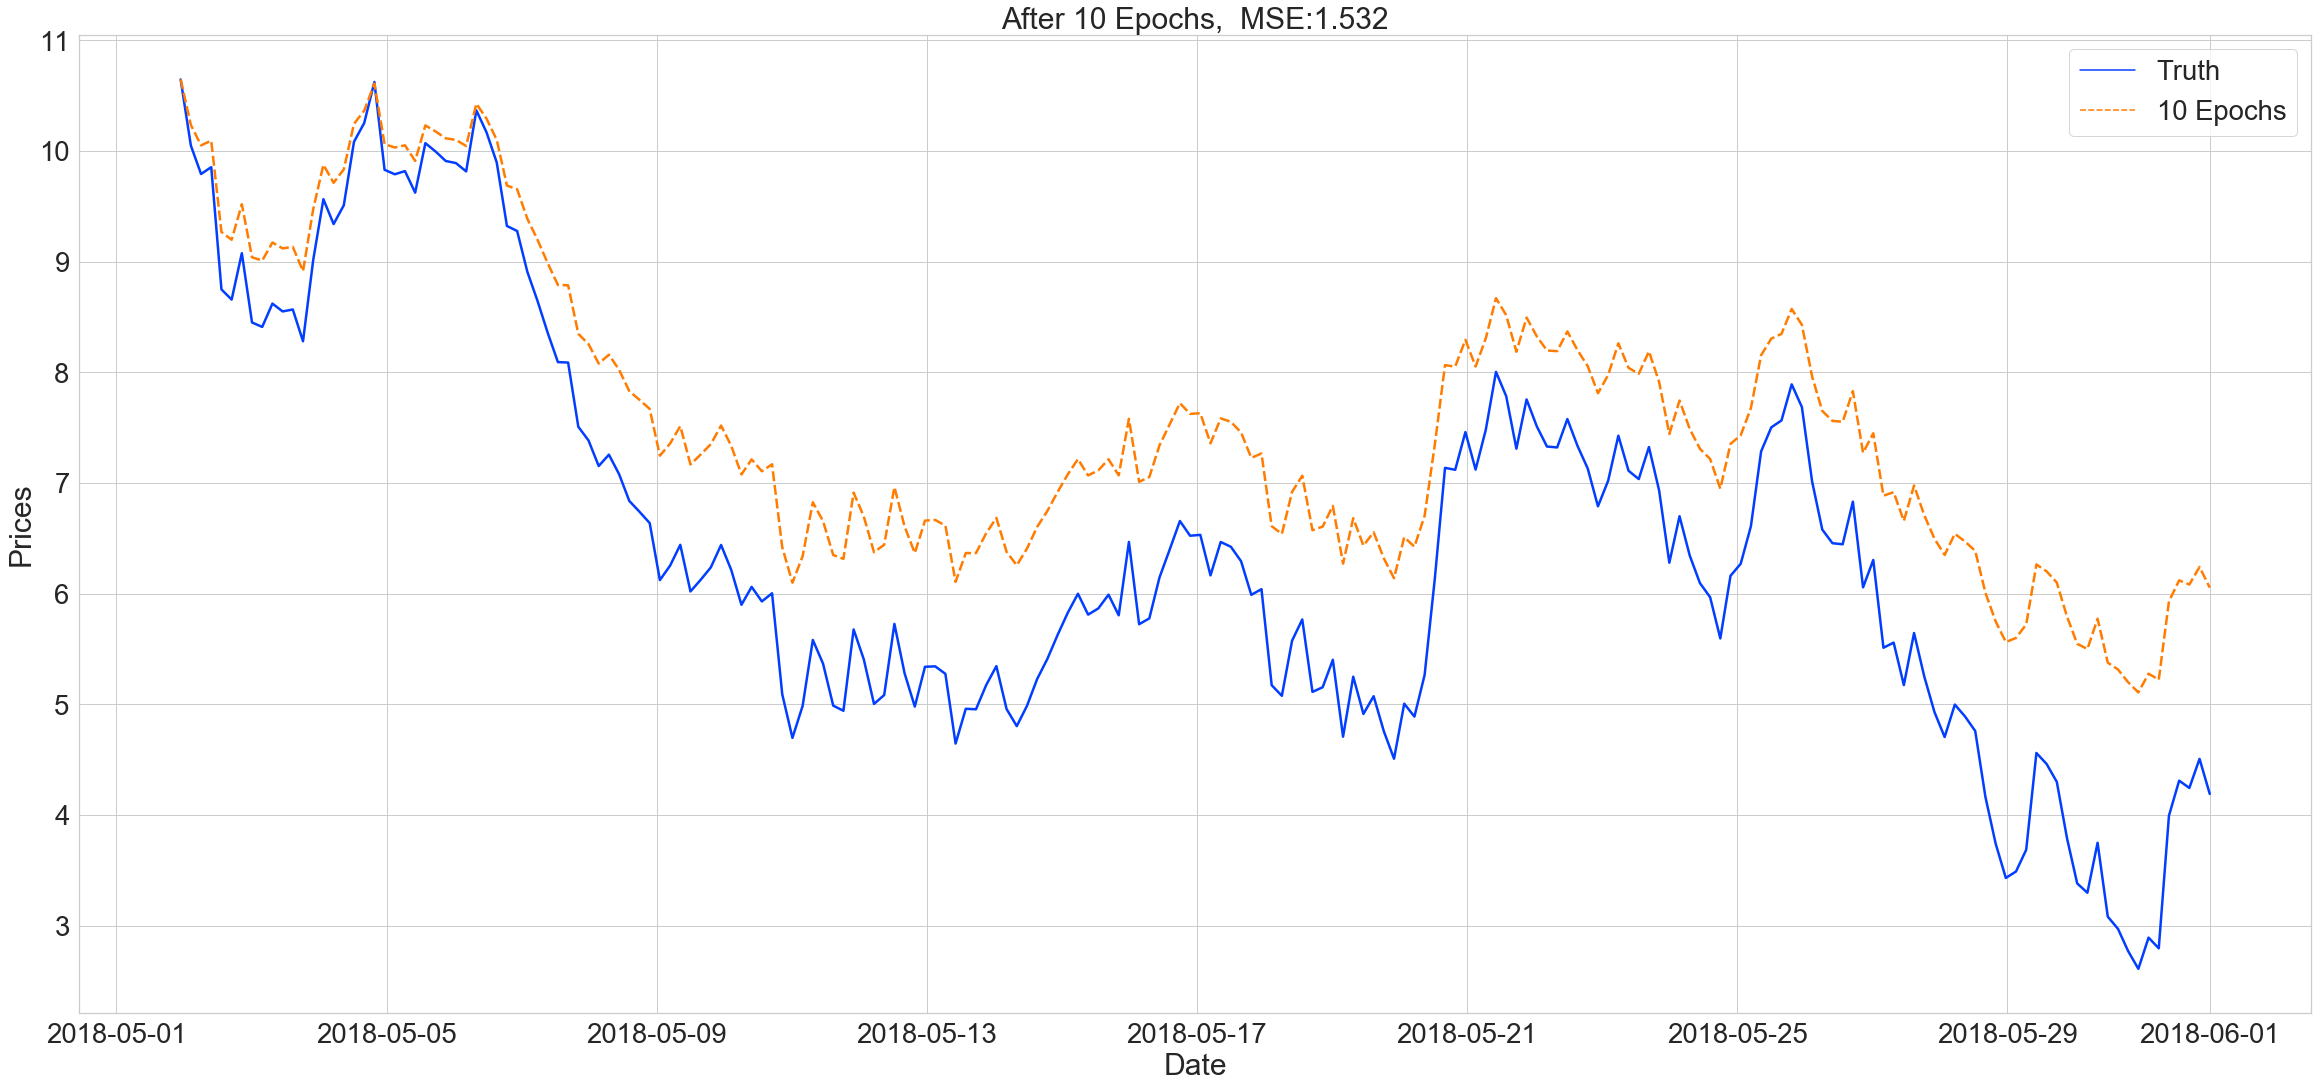

In [167]:
plt.figure(figsize=(40, 18))
ax = sns.lineplot(
    data=all_preds[["Truth", "10 Epochs"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices',
       title=f'After 10 Epochs,  MSE:{round(mean_squared_error(all_preds.Truth, all_preds["10 Epochs"]), 3)}')

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'After 100 Epochs,  MSE:0.7')]

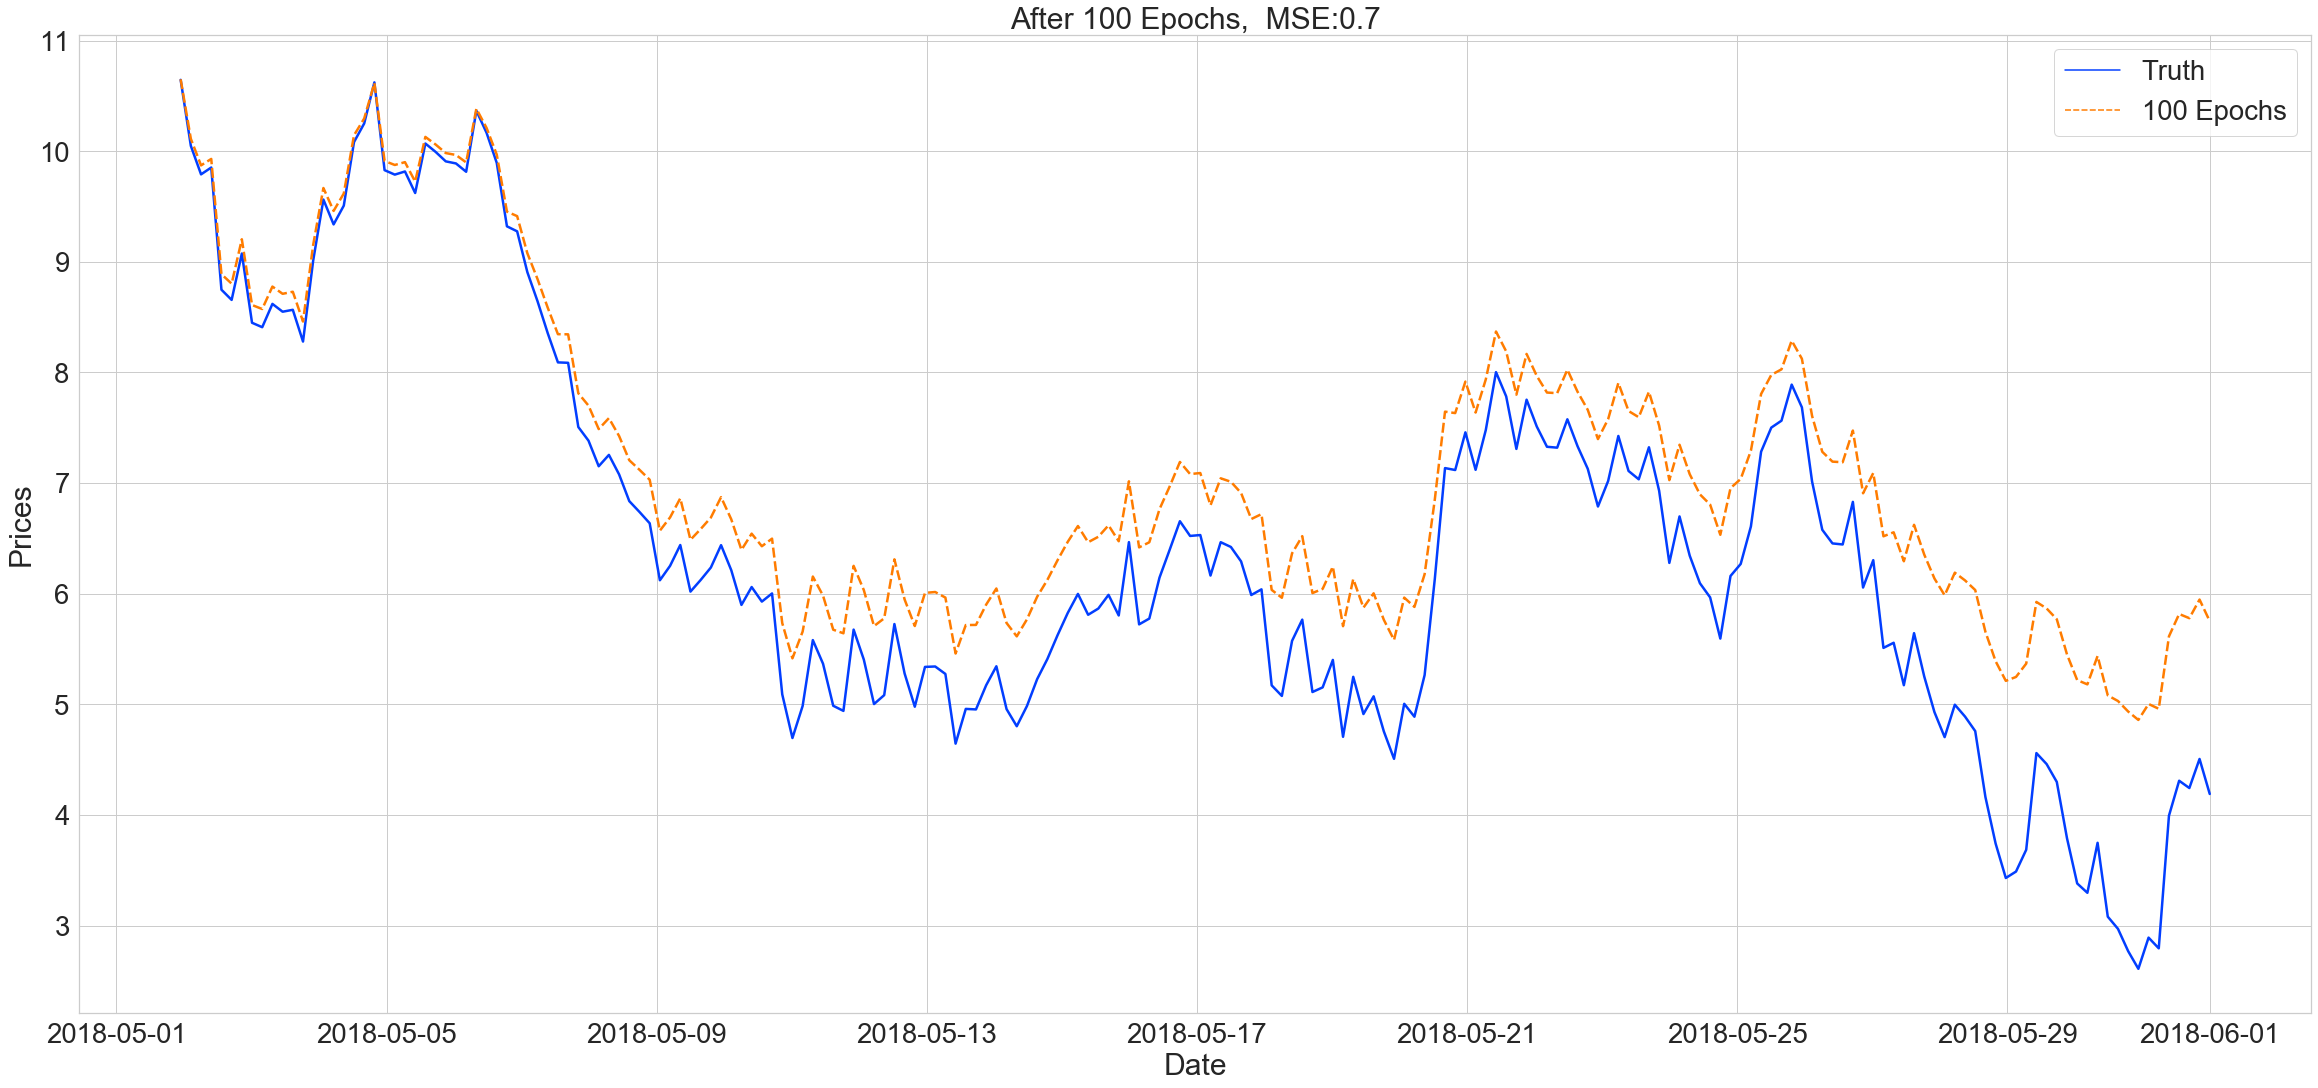

In [168]:
plt.figure(figsize=(40, 18))
ax = sns.lineplot(
    data=all_preds[["Truth", "100 Epochs"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices',
       title=f'After 100 Epochs,  MSE:{round(mean_squared_error(all_preds.Truth, all_preds["100 Epochs"]), 3)}')

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'After 200 Epochs,  MSE:0.401')]

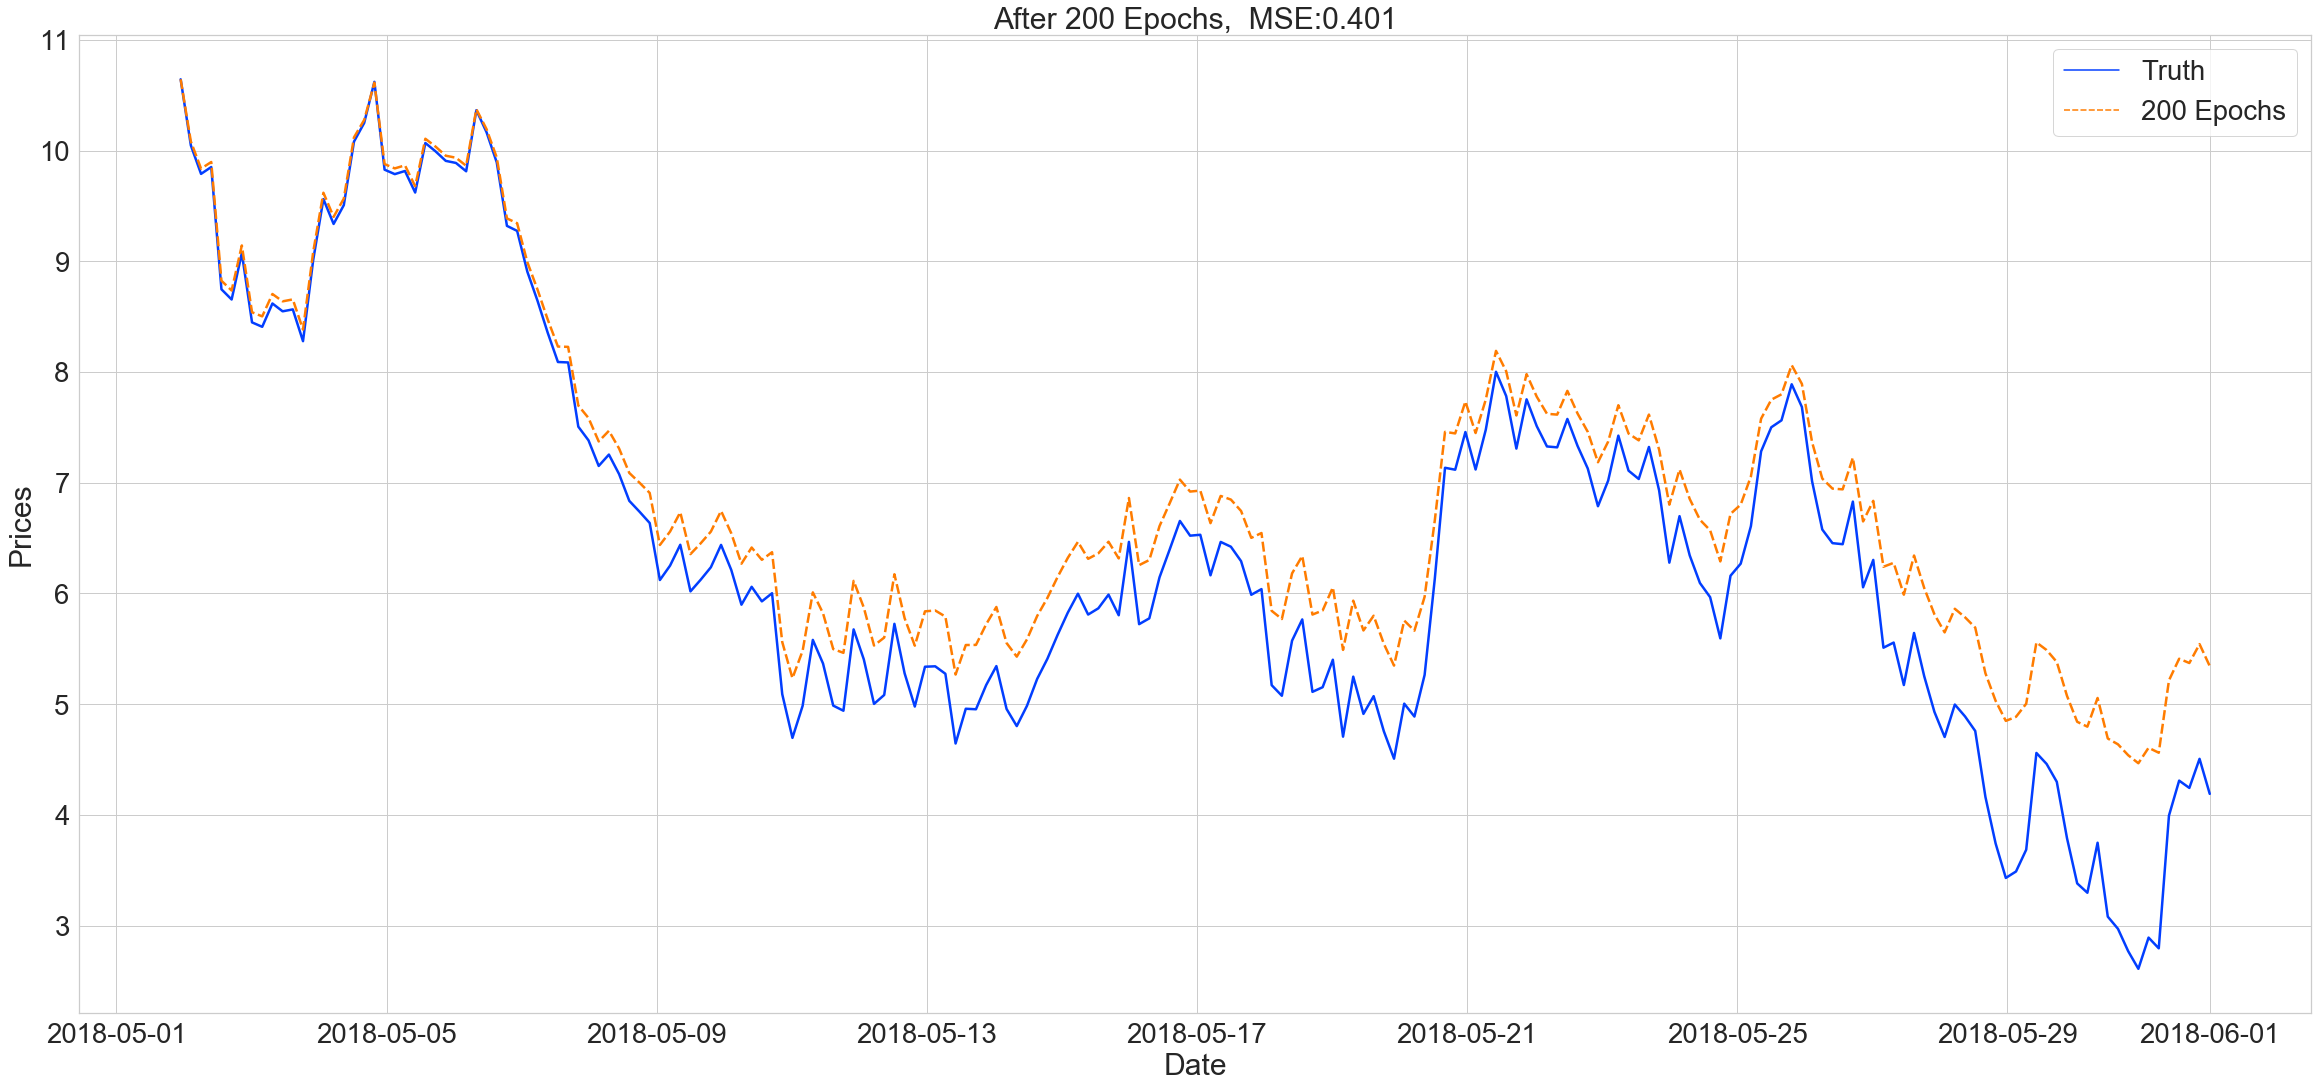

In [169]:
plt.figure(figsize=(40, 18))
ax = sns.lineplot(
    data=all_preds[["Truth", "200 Epochs"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices',
       title=f'After 200 Epochs,  MSE:{round(mean_squared_error(all_preds.Truth, all_preds["200 Epochs"]), 3)}')

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'After 1000 Epochs,  MSE:0.386')]

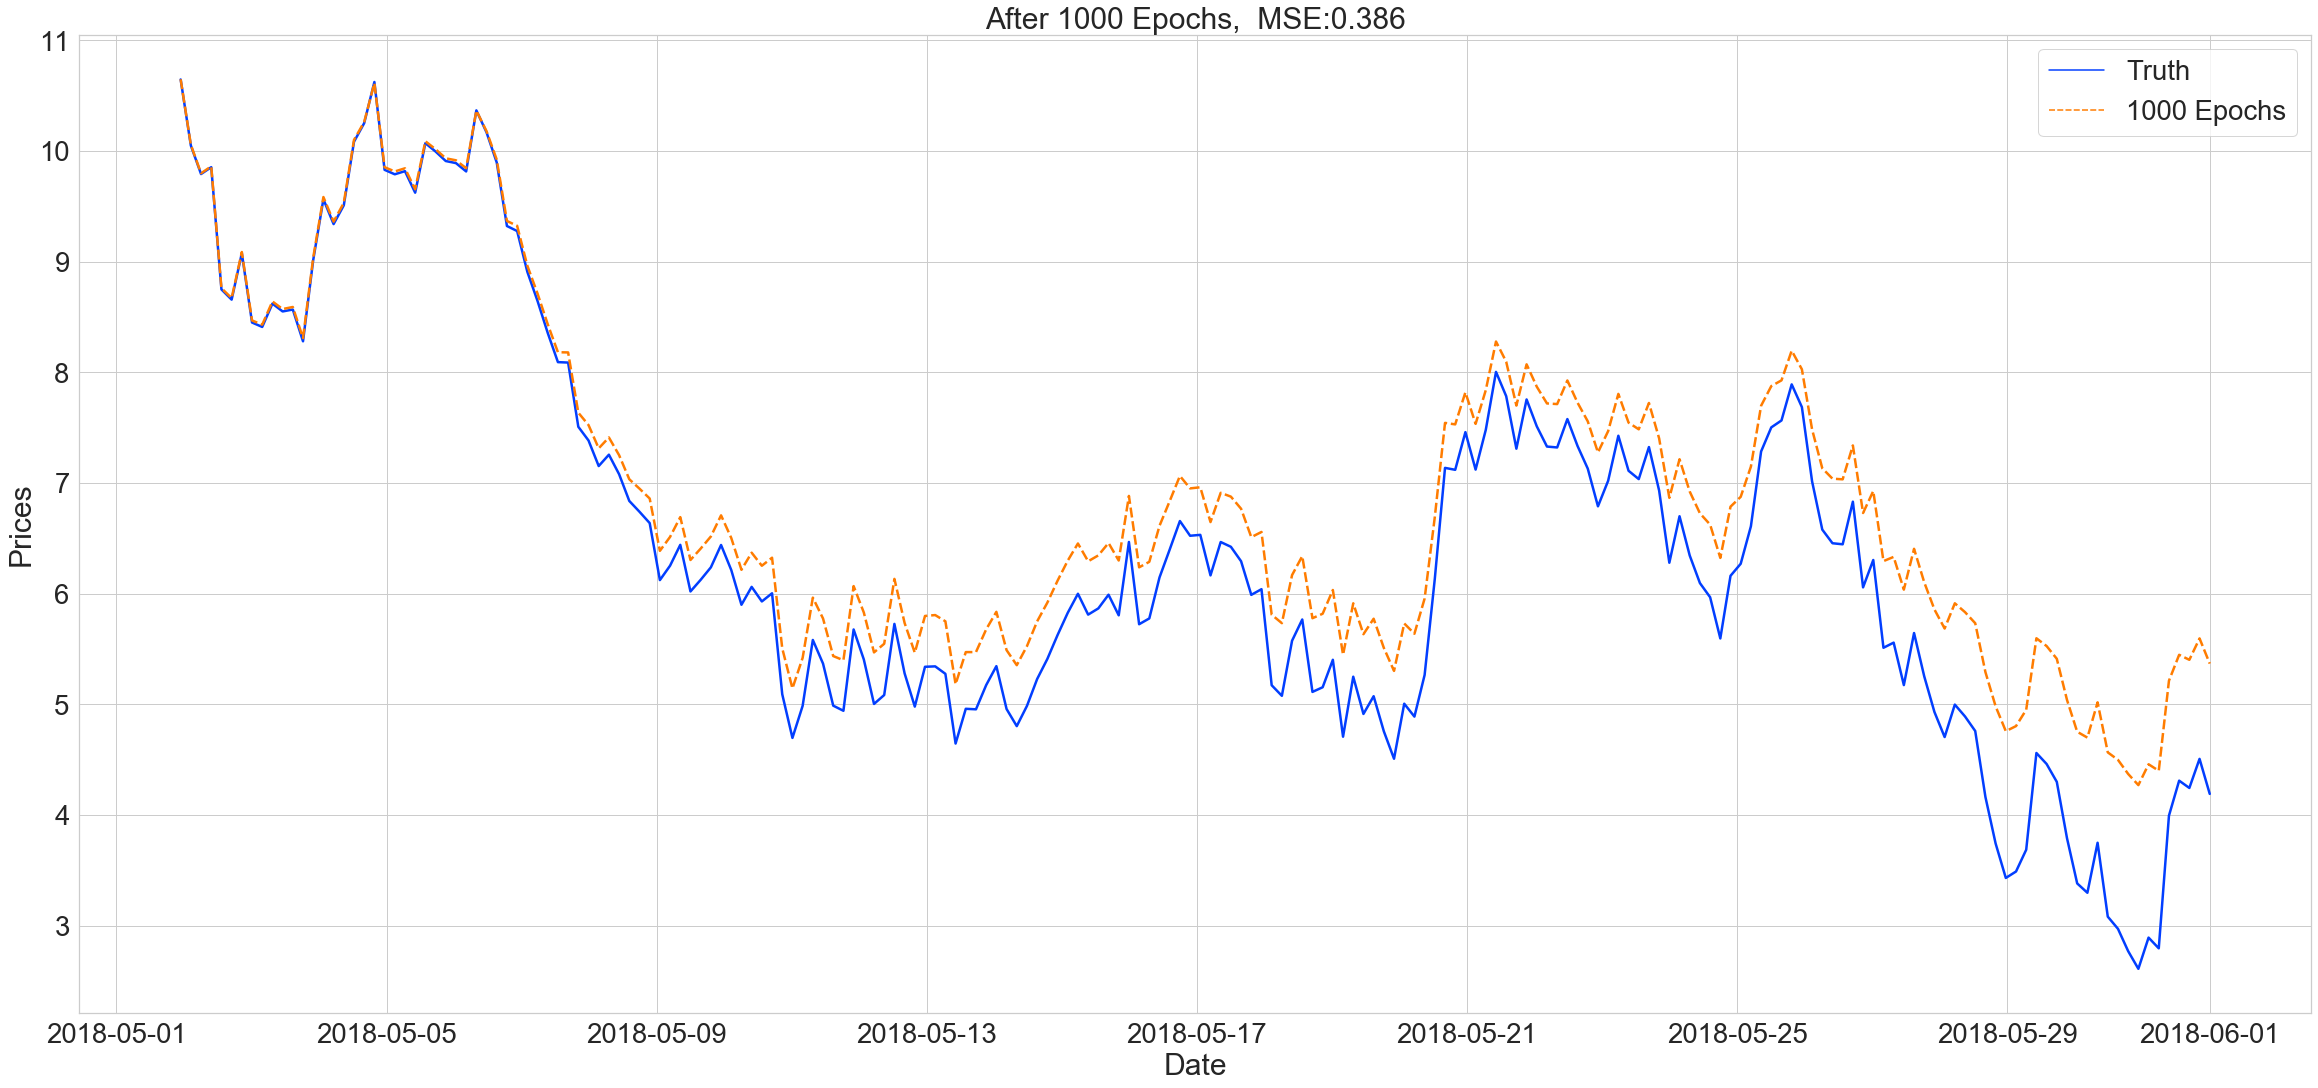

In [170]:
plt.figure(figsize=(40, 18))
ax = sns.lineplot(
    data=all_preds[["Truth", "1000 Epochs"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices',
       title=f'After 1000 Epochs,  MSE:{round(mean_squared_error(all_preds.Truth, all_preds["1000 Epochs"]), 3)}')

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'After 5000 Epochs,  MSE:0.21')]

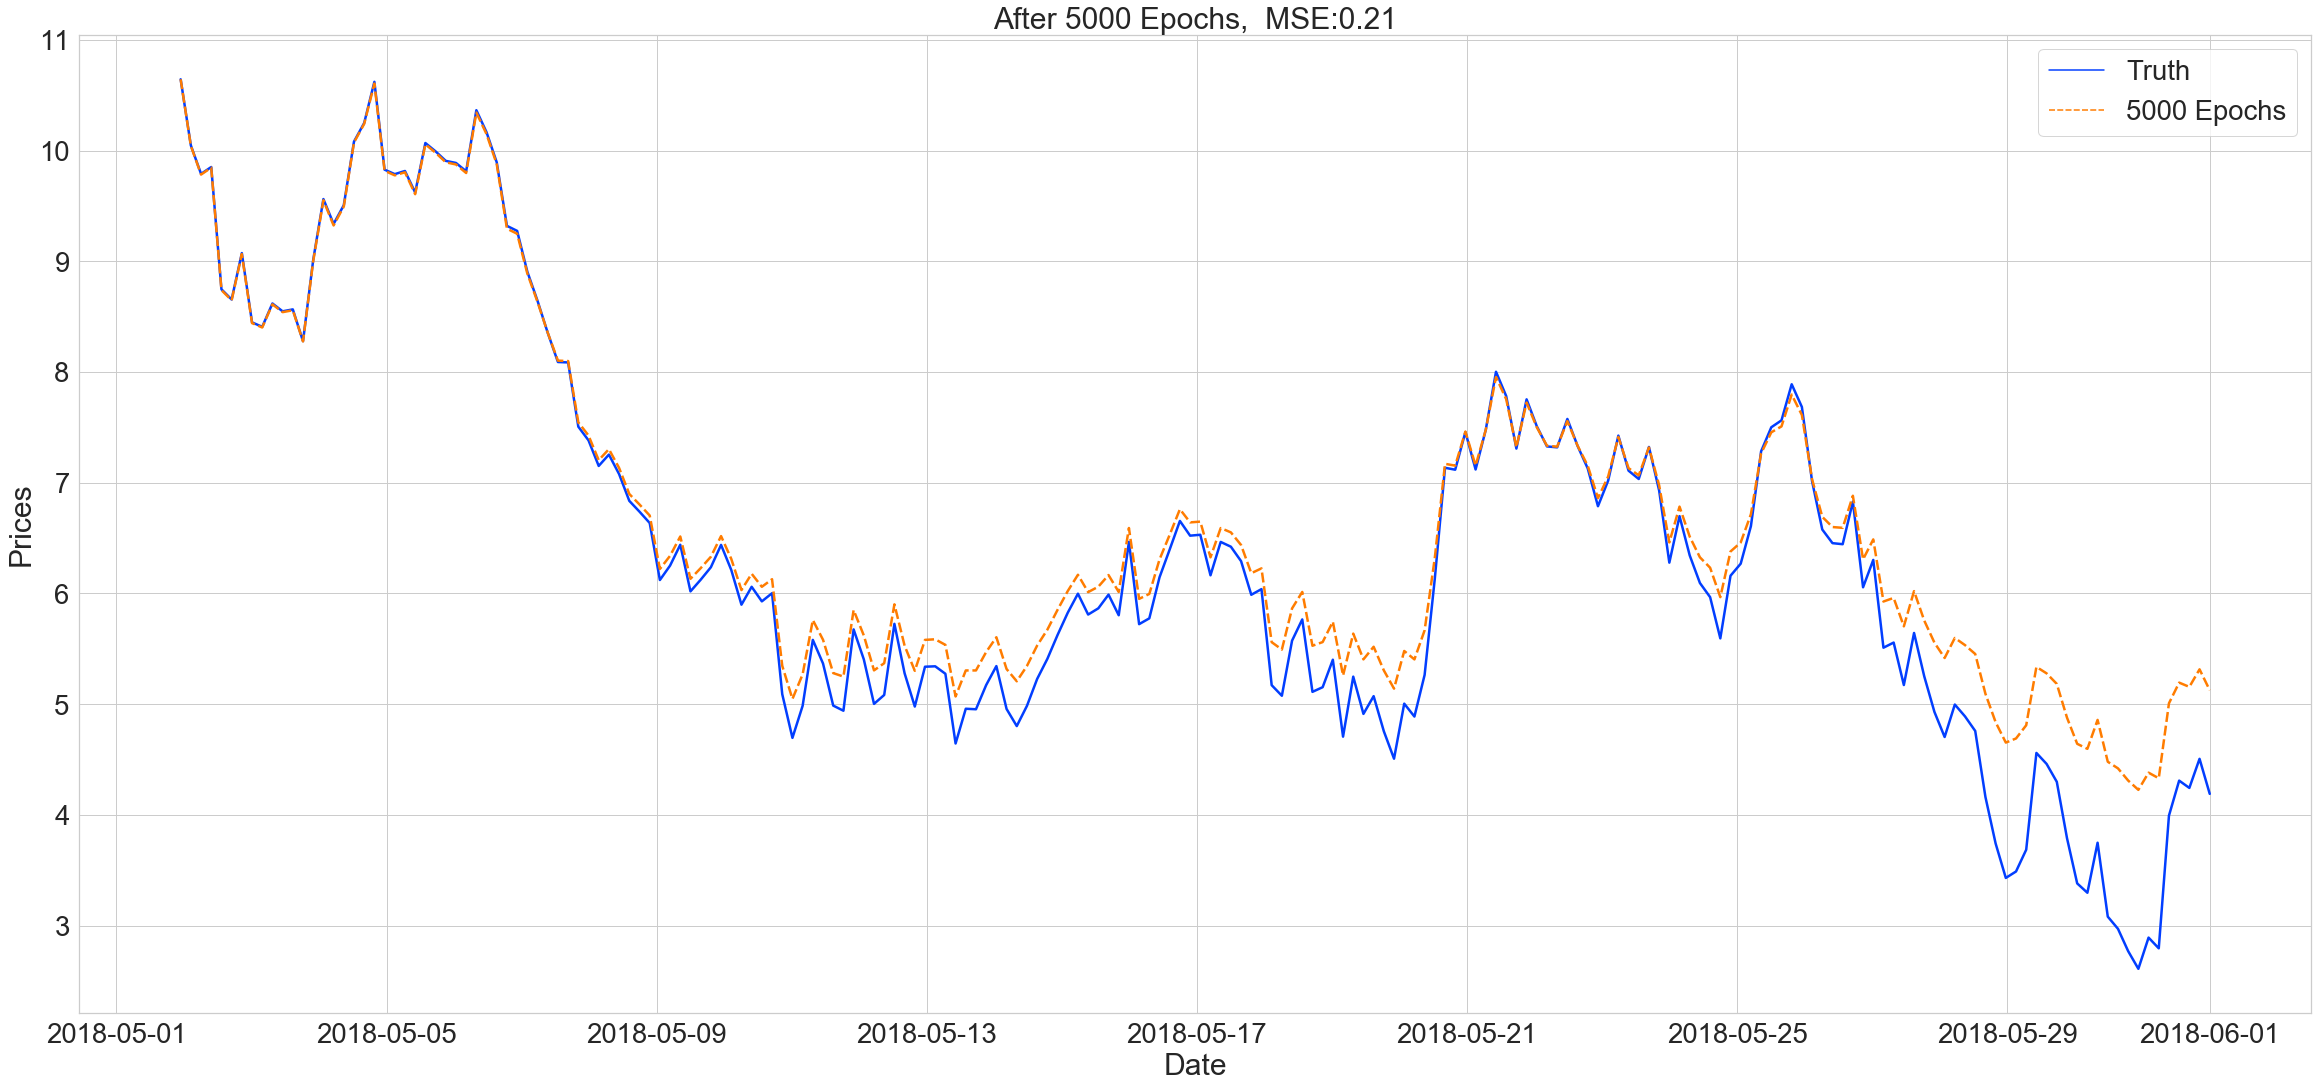

In [171]:
plt.figure(figsize=(40, 18))
ax = sns.lineplot(
    data=all_preds[["Truth", "5000 Epochs"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices',
       title=f'After 5000 Epochs,  MSE:{round(mean_squared_error(all_preds.Truth, all_preds["5000 Epochs"]), 3)}')

# Do list

 - Mini-batch Gradient Descent
 - Adam Optimization
 - Approximating first derivative with respect to spot, delta hedging
 - Extensions to exotic options, comparison with Monte-Carlo approach